## Regression model

### 数据处理 

In [1]:
import numpy as np
import pandas as pd
import os
import hyperopt
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from numpy.random import RandomState
from matplotlib import rcParams

workDir = 'D:/Documents/outfile/RF_input_newmodel_2505/response_add_analysis'
os.chdir(workDir)
data = pd.read_csv('RF_input_BAfwiNDVITCEBAAgeDEMSPEISMT2mTPPETVPDPETRoaddensityPopuENFBiomassWSTmaxLightningLandSpeciesSnowCanopyheight.csv')
print("columns:", data.columns)

# 删除数据中TC列为空的行
data = data.dropna(subset=['tree_cover'])
# 删除数据中TC列小于0.15的行
#data = data.drop(data[data['tree_cover'] < 0.15].index)
# 将数据中EF列为空的行替换为0
data['ENF'] = data['ENF'].fillna(0)
# 将数据中EBA列为空的行替换为0
data['black spruce'] = data['black spruce'].fillna(0)
# 2505
data["ENF"] = data["ENF"]-data["black spruce"]

data['Embracer'] = data['Embracer'].fillna(0)
data['Resister'] = data['Resister'].fillna(0)
data['Avoider'] = data['Avoider'].fillna(0)
data['Invader'] = data['Invader'].fillna(0)
data['Endurer'] = data['Endurer'].fillna(0)
''''''
# 将数据中Roaddensity,Popu列为空的行替换为0
data['Road density'] = data['Road density'].fillna(0)
data['Population density'] = data['Population density'].fillna(0)
# 删除所有空值行
# data.to_csv('temp_out.csv', index=False)
print('lenth of data:', len(data))
# 查看是否依然存在空值
null_value_stats = data.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]
print(len(null_value_stats))

# 创建P_PET列
data['P_PET'] = data['TP'] - data['PET']


# 分别获取20、21、22、23年的数据
data_20 = data[data['YR'] == 2020]
data_21 = data[data['YR'] == 2021]
data_22 = data[data['YR'] == 2022]
data_23 = data[data['YR'] == 2023]


# 输出数据长度
print(len(data_20))
print(len(data_21))
print(len(data_22))
print(len(data_23))

columns: Index(['YR', 'BA_fraction', 'lat', 'lon', 'fwiID', 'LAT', 'LONG', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'DSR', 'ROW', 'COL', 'NDVI',
       'tree_cover', 'black spruce', 'forest_age', 'elevation', 'SPEI', 'SWC',
       'T2M', 'TP', 'PET0', 'VPD', 'PET', 'Road density', 'Population density',
       'ENF', 'Biomass', 'WS', 'T2Mmax', 'Lightning', 'water', 'wetland',
       'moss', 'cropland', 'barren', 'grassland', 'Avoider', 'Endurer',
       'Invader', 'Embracer', 'Resister', 'Snow', 'canopy_height'],
      dtype='object')
lenth of data: 13192
48
1054
3103
1902
7133


### features

In [2]:
predictors = ["FFMC","ISI","BUI","DMC",'DC','FWI',
                "NDVI",
                "tree_cover",
                "ENF",
                "forest_age", 'Biomass', "canopy_height",
                "Road density","Population density",
                'elevation',
                "black spruce",
                "Lightning",
                "water", "wetland", "barren", "grassland", "cropland","moss",
                "Embracer",
                "Resister", "Avoider", "Invader", "Endurer",
                #"lon", "lat",
                "SPEI", "PET", 
                "SWC", "Snow",
                "VPD","TP","WS", "T2Mmax", #"T2M",
                "BA_fraction"]
                                
# 选择特征列
data_pro  = data[predictors]

data_20_pro = data_20[predictors]
data_21_pro = data_21[predictors]
data_22_pro = data_22[predictors]
data_23_pro = data_23[predictors]
data_23_pro_extrem = data_23_pro[data_23_pro['BA_fraction'] >= 0.1]
data_23_pro_norm = data_23_pro[data_23_pro['BA_fraction'] <= 0.1]
data_his_pro = pd.concat([data_20_pro, data_21_pro, data_22_pro])

# 删除缺失值
# data_20_pro = data_20_pro.dropna()
# data_21_pro = data_21_pro.dropna()
# data_22_pro = data_22_pro.dropna()
# data_23_pro = data_23_pro.dropna()

X = data_pro.drop('BA_fraction', axis=1)
y = data_pro.BA_fraction

# # 对20-23年数据划分x,y
# X_20 = data_20_pro[predictors].drop('BA_fraction', axis=1)
# y_20 = data_20_pro.BA_fraction
# X_21 = data_21_pro[predictors].drop('BA_fraction', axis=1)
# y_21 = data_21_pro.BA_fraction
# X_22 = data_22_pro[predictors].drop('BA_fraction', axis=1)
# y_22 = data_22_pro.BA_fraction
# X_23 = data_23_pro[predictors].drop('BA_fraction', axis=1)
# y_23 = data_23_pro.BA_fraction

# # 选出20-22年的数据作为训练集
# X_his = pd.concat([X_20, X_21, X_22])
# y_his = pd.concat([y_20, y_21, y_22])

# # 将数据划分为普通数据和极端数据
# X_23_extrem = data_23_pro_extrem.drop('BA_fraction', axis=1)
# y_23_extrem = data_23_pro_extrem.BA_fraction
# X_23_norm = data_23_pro_norm.drop('BA_fraction', axis=1)
# y_23_norm = data_23_pro_norm.BA_fraction


# print(X_23.head())
# print(y_23.head())

### 共线性计算

#### 相关性计算

Correlation matrix (first 5 rows):
          FFMC       ISI       BUI       DMC        DC       FWI      NDVI  \
FFMC  1.000000  0.874255  0.863430  0.840965  0.879738  0.890788  0.166689   
ISI   0.874255  1.000000  0.834573  0.831092  0.809277  0.946027  0.053955   
BUI   0.863430  0.834573  1.000000  0.990200  0.941358  0.963915  0.107920   
DMC   0.840965  0.831092  0.990200  1.000000  0.898239  0.955566  0.121554   
DC    0.879738  0.809277  0.941358  0.898239  1.000000  0.920525  0.025790   

      tree_cover       ENF  forest_age  ...   Invader   Endurer      SPEI  \
FFMC   -0.080306 -0.048783    0.039124  ... -0.185716  0.272880  0.007668   
ISI    -0.192531 -0.160399   -0.082217  ... -0.143170  0.223052  0.000913   
BUI    -0.085535  0.019878    0.007922  ... -0.146663  0.269760  0.029413   
DMC    -0.077662  0.025841    0.006879  ... -0.129389  0.258427  0.070432   
DC     -0.134263  0.001949   -0.023958  ... -0.197660  0.197912 -0.104396   

           PET       SWC      Sno

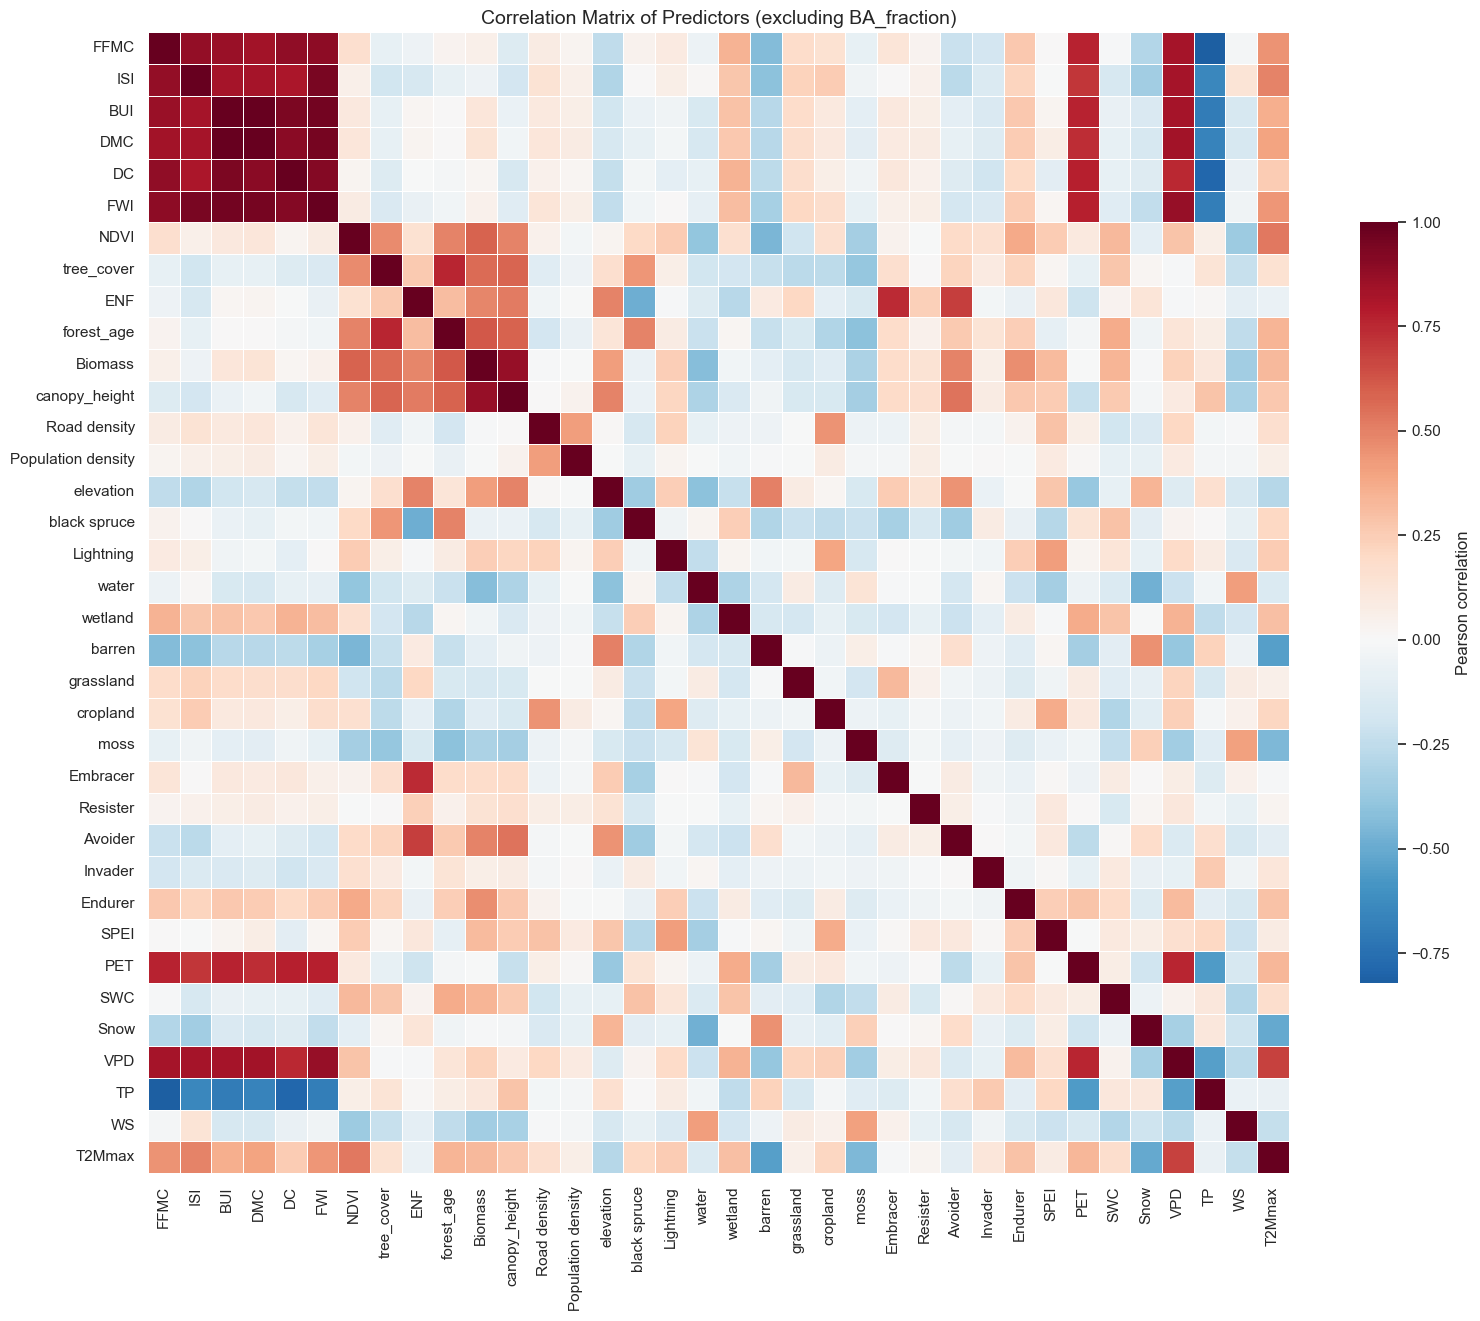

[('ISI', 'FFMC'), ('BUI', 'FFMC'), ('BUI', 'ISI'), ('DMC', 'FFMC'), ('DMC', 'ISI'), ('DMC', 'BUI'), ('DC', 'FFMC'), ('DC', 'ISI'), ('DC', 'BUI'), ('DC', 'DMC'), ('FWI', 'FFMC'), ('FWI', 'ISI'), ('FWI', 'BUI'), ('FWI', 'DMC'), ('FWI', 'DC'), ('forest_age', 'tree_cover'), ('canopy_height', 'Biomass'), ('Embracer', 'ENF'), ('PET', 'FFMC'), ('PET', 'ISI'), ('PET', 'BUI'), ('PET', 'DMC'), ('PET', 'DC'), ('PET', 'FWI'), ('VPD', 'FFMC'), ('VPD', 'ISI'), ('VPD', 'BUI'), ('VPD', 'DMC'), ('VPD', 'DC'), ('VPD', 'FWI'), ('VPD', 'PET'), ('TP', 'FFMC'), ('TP', 'DC')]


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算除 BA_fraction 外的相关性矩阵
corr_matrix = data_23_pro.drop(columns=["BA_fraction"]).corr()

# 打印前几行相关系数矩阵
print("Correlation matrix (first 5 rows):")
print(corr_matrix.head())

# 打印相关性大于0.7或小于-0.7的变量对
threshold = 0.7
colinearity_couplers = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            print(f"High correlation: {corr_matrix.columns[i]} and {corr_matrix.columns[j]} = {corr_matrix.iloc[i, j]}")
            colinearity_couplers.append((corr_matrix.columns[i], corr_matrix.columns[j]))


# 设置图像大小和样式
plt.figure(figsize=(16, 14))
sns.set(style="white")

# 绘制热图
sns.heatmap(
    corr_matrix,
    cmap="RdBu_r",          # 红蓝对比色
    center=0,               # 以 0 为中心
    square=True,            # 方形格子
    linewidths=0.5,         # 网格线宽
    cbar_kws={"shrink": 0.6, "label": "Pearson correlation"}
)

plt.title("Correlation Matrix of Predictors (excluding BA_fraction)", fontsize=14)
plt.tight_layout()
plt.show()
print(colinearity_couplers)

### 逐步机器学习

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

normal_predictors = [# "FFMC","ISI","BUI","DMC",'DC','FWI',
                "NDVI",
               # "tree_cover", "forest_age",
                "ENF",
                #'Biomass', "canopy_height",
                "Road density","Population density",
                'elevation',
                "black spruce",
                "Lightning",
                "water", "wetland", "barren", "grassland", "cropland","moss",
                "Embracer",
                "Resister", "Avoider", "Invader", "Endurer",
                #"lon", "lat",
                "SPEI",  
                "SWC", "Snow",
                "TP","WS", #"T2Mmax","VPD", #"PET", #"T2M",
                ]  # Removed "BA_fraction" from normal_predictors
colinearity_predictors = [
                    "tree_cover", "forest_age",
                    'Biomass', "canopy_height",
                    "T2Mmax","VPD",  "PET", 
                    "FFMC","ISI","BUI","DMC",'DC','FWI',
                    ]
X_23_normal = data_23_pro[normal_predictors]
X_23_colinearity = data_23_pro[colinearity_predictors]
y_23 = data_23_pro['BA_fraction']

# 构建基础模型（线性回归用于前向选择）
lr = LinearRegression()

# 用 mlxtend 的 SFS 做前向选择：固定 normal_predictors，选择 colinearity_predictors 中最优子集
# 利用 fixed_features 参数将 normal_predictors 保留
all_X_23 = pd.concat([X_23_normal, X_23_colinearity], axis=1)

sfs = SFS(estimator=lr,
          k_features='best',           #
          forward=True,
          floating=False,
          fixed_features=tuple(range(len(normal_predictors))),  # 假定 normal predictors 在前几列
          scoring='r2',
          cv=4,
          verbose=2)

sfs = sfs.fit(all_X_23, y_23)
print("Selected feature names:", sfs.k_feature_names_)

selected_features = [all_X_23.columns[i] for i in sfs.k_feature_idx_]
selected_col_vars = [f for f in selected_features if f in colinearity_predictors]
print("Selected from colinearity_predictors:", selected_col_vars)

final_predictors = normal_predictors + selected_col_vars
print("Final predictors for ML model:", final_predictors)

print('Best accuracy score: %.2f' % sfs.k_score_)


# 后向选择剔除
sfs_predictors = final_predictors
X_23_sfs = data_23_pro[sfs_predictors]
y_23 = data_23_pro['BA_fraction']

# SBS
sbs = SFS(estimator=lr,
          k_features="best",
          forward=False,
          floating=False,
          scoring='r2',
          cv=4,
          verbose=2)
sbs = sbs.fit(X_23_sfs, y_23)
print("Selected feature names after SBS:", sbs.k_feature_names_)
selected_sbs_features = [X_23_sfs.columns[i] for i in sbs.k_feature_idx_]
print("Final predictors after SBS for ML model:", selected_sbs_features)
# removed features
removed_features = [f for f in sfs_predictors if f not in selected_sbs_features]
print("Removed features after SBS:", removed_features)


[2025-10-27 12:20:04] Features: 24/36 -- score: 0.09693186272153789
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 -- score: -0.04293636347298058
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 --


[2025-10-27 12:20:04] Features: 24/36 -- score: 0.09693186272153789
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 -- score: -0.04293636347298058
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 --

Selected feature names: ('NDVI', 'ENF', 'Road density', 'Population density', 'elevation', 'black spruce', 'Lightning', 'water', 'wetland', 'barren', 'grassland', 'cropland', 'moss', 'Embracer', 'Resister', 'Avoider', 'Invader', 'Endurer', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'tree_cover', 'forest_age', 'T2Mmax')
Selected from colinearity_predictors: ['tree_cover', 'forest_age', 'T2Mmax']
Final predictors for ML model: ['NDVI', 'ENF', 'Road density', 'Population density', 'elevation', 'black spruce', 'Lightning', 'water', 'wetland', 'barren', 'grassland', 'cropland', 'moss', 'Embracer', 'Resister', 'Avoider', 'Invader', 'Endurer', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'tree_cover', 'forest_age', 'T2Mmax']
Best accuracy score: 0.11



[2025-10-27 12:20:04] Features: 24/36 -- score: 0.09693186272153789
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 -- score: -0.04293636347298058
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 --

Selected feature names: ('NDVI', 'ENF', 'Road density', 'Population density', 'elevation', 'black spruce', 'Lightning', 'water', 'wetland', 'barren', 'grassland', 'cropland', 'moss', 'Embracer', 'Resister', 'Avoider', 'Invader', 'Endurer', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'tree_cover', 'forest_age', 'T2Mmax')
Selected from colinearity_predictors: ['tree_cover', 'forest_age', 'T2Mmax']
Final predictors for ML model: ['NDVI', 'ENF', 'Road density', 'Population density', 'elevation', 'black spruce', 'Lightning', 'water', 'wetland', 'barren', 'grassland', 'cropland', 'moss', 'Embracer', 'Resister', 'Avoider', 'Invader', 'Endurer', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'tree_cover', 'forest_age', 'T2Mmax']
Best accuracy score: 0.11



[2025-10-27 12:20:07] Features: 25/1 -- score: 0.1436078007122628
[2025-10-27 12:20:08] Features: 24/1 -- score: 0.15894641581100588
[2025-10-27 12:20:08] Features: 24/1 -- score: 0.15894641581100588
[2025-10-27 12:20:09] Features: 23/1 -- score: 0.1676181357312246
[2025-10-27 12:20:09] Features: 23/1 -- score: 0.1676181357312246
[2025-10-27 12:20:09] Features: 22/1 -- score: 0.17372174841983923
[2025-10-27 12:20:09] Features: 22/1 -- score: 0.17372174841983923
[2025-10-27 12:20:10] Features: 21/1 -- score: 0.17636848944625727
[2025-10-27 12:20:10] Features: 20/1 -- score: 0.1779444749306848
[2025-10-27 12:20:10] Features: 21/1 -- score: 0.17636848944625727
[2025-10-27 12:20:10] Features: 20/1 -- score: 0.1779444749306848
[2025-10-27 12:20:10] Features: 19/1 -- score: 0.17942061860896794
[2025-10-27 12:20:10] Features: 18/1 -- score: 0.18177331501105715
[2025-10-27 12:20:10] Features: 19/1 -- score: 0.17942061860896794
[2025-10-27 12:20:10] Features: 18/1 -- score: 0.18177331501105715


[2025-10-27 12:20:04] Features: 24/36 -- score: 0.09693186272153789
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:04] Features: 25/36 -- score: 0.10575311779969873
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 26/36 -- score: 0.10588012442194492
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 27/36 -- score: 0.10536319418139553
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:05] Features: 28/36 -- score: 0.08574836639082306
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 29/36 -- score: 0.021151723096914127
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 -- score: -0.04293636347298058
[2025-10-27 12:20:06] Features: 30/36 -- score: -0.014198151596562625
[2025-10-27 12:20:06] Features: 31/36 --

Selected feature names: ('NDVI', 'ENF', 'Road density', 'Population density', 'elevation', 'black spruce', 'Lightning', 'water', 'wetland', 'barren', 'grassland', 'cropland', 'moss', 'Embracer', 'Resister', 'Avoider', 'Invader', 'Endurer', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'tree_cover', 'forest_age', 'T2Mmax')
Selected from colinearity_predictors: ['tree_cover', 'forest_age', 'T2Mmax']
Final predictors for ML model: ['NDVI', 'ENF', 'Road density', 'Population density', 'elevation', 'black spruce', 'Lightning', 'water', 'wetland', 'barren', 'grassland', 'cropland', 'moss', 'Embracer', 'Resister', 'Avoider', 'Invader', 'Endurer', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'tree_cover', 'forest_age', 'T2Mmax']
Best accuracy score: 0.11



[2025-10-27 12:20:07] Features: 25/1 -- score: 0.1436078007122628
[2025-10-27 12:20:08] Features: 24/1 -- score: 0.15894641581100588
[2025-10-27 12:20:08] Features: 24/1 -- score: 0.15894641581100588
[2025-10-27 12:20:09] Features: 23/1 -- score: 0.1676181357312246
[2025-10-27 12:20:09] Features: 23/1 -- score: 0.1676181357312246
[2025-10-27 12:20:09] Features: 22/1 -- score: 0.17372174841983923
[2025-10-27 12:20:09] Features: 22/1 -- score: 0.17372174841983923
[2025-10-27 12:20:10] Features: 21/1 -- score: 0.17636848944625727
[2025-10-27 12:20:10] Features: 20/1 -- score: 0.1779444749306848
[2025-10-27 12:20:10] Features: 21/1 -- score: 0.17636848944625727
[2025-10-27 12:20:10] Features: 20/1 -- score: 0.1779444749306848
[2025-10-27 12:20:10] Features: 19/1 -- score: 0.17942061860896794
[2025-10-27 12:20:10] Features: 18/1 -- score: 0.18177331501105715
[2025-10-27 12:20:10] Features: 19/1 -- score: 0.17942061860896794
[2025-10-27 12:20:10] Features: 18/1 -- score: 0.18177331501105715

Selected feature names after SBS: ('Population density', 'black spruce', 'Lightning', 'water', 'cropland', 'moss', 'Embracer', 'Avoider', 'Invader', 'SPEI', 'Snow', 'TP', 'WS', 'T2Mmax')
Final predictors after SBS for ML model: ['Population density', 'black spruce', 'Lightning', 'water', 'cropland', 'moss', 'Embracer', 'Avoider', 'Invader', 'SPEI', 'Snow', 'TP', 'WS', 'T2Mmax']
Removed features after SBS: ['NDVI', 'ENF', 'Road density', 'elevation', 'wetland', 'barren', 'grassland', 'Resister', 'Endurer', 'SWC', 'tree_cover', 'forest_age']



[2025-10-27 12:20:11] Features: 7/1 -- score: 0.17099918782461337
[2025-10-27 12:20:12] Features: 6/1 -- score: 0.1610599815893683
[2025-10-27 12:20:12] Features: 5/1 -- score: 0.14677059202451448
[2025-10-27 12:20:12] Features: 4/1 -- score: 0.1412492581773683
[2025-10-27 12:20:12] Features: 3/1 -- score: 0.13329785890541668
[2025-10-27 12:20:12] Features: 2/1 -- score: 0.07502586369900172
[2025-10-27 12:20:12] Features: 1/1 -- score: 0.0447416155731519

## 2023 model

### 变量对Catboost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error



# === 1. 找出高相关变量对 ===
threshold = 0.7
corr_matrix = data_23_pro.drop(columns=["BA_fraction"]).corr()
colinearity_couplers = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i in range(len(corr_matrix.columns))
    for j in range(i)
    if abs(corr_matrix.iloc[i, j]) > threshold
]
print(f"找到 {len(colinearity_couplers)} 对高相关变量。\n")

# === 2. 初始化 ===
# 取出colinearity_predictors的唯一值
colinearity_predictors = set()
for pair in colinearity_couplers:
    colinearity_predictors.update(pair)
# 转为列表
colinearity_predictors = list(colinearity_predictors)
# 从所有变量中移除高相关变量，得到正常变量列表
normal_predictors = [col for col in data_23_pro.columns if col != "BA_fraction" and col not in colinearity_predictors]
all_predictors = normal_predictors + colinearity_predictors
# 初始输入变量集为正常变量集合
input_predictors = set(all_predictors.copy())
removed_predictors = set()

# === 3. 固定数据划分 ===
X_all = data_23_pro.drop(columns=["BA_fraction"])
y_all = data_23_pro["BA_fraction"]
y_bins = pd.qcut(y_all, q=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, train_size=0.8, stratify=y_bins, random_state=23, shuffle=True
)

# === 4. 模型构建函数 ===
def build_model():
    return CatBoostRegressor(
        l2_leaf_reg=60,
        learning_rate=0.0999278052,
        depth=8,
        iterations=1500,
        random_seed=42,
        subsample=0.9,
        rsm=0.9,
        eval_metric="RMSE",
        verbose=False,
        use_best_model=True,
        od_type="Iter",
        od_wait=300
    )

# === 5. 遍历每对高相关变量 ===
for idx, (pred1, pred2) in enumerate(colinearity_couplers):
    print(f"\n{'='*70}")
    print(f"[{idx+1}/{len(colinearity_couplers)}] 当前测试的变量对：({pred1}, {pred2})")
    
    # 检查是否已经被删除
    if pred1 in removed_predictors and pred2 in removed_predictors:
        print(f"⏭️ 两个变量都已被删除，跳过")
        continue
    elif pred1 in removed_predictors:
        print(f"⏭️ {pred1} 已被删除，自动保留 {pred2}")
        input_predictors.add(pred2)
        continue
    elif pred2 in removed_predictors:
        print(f"⏭️ {pred2} 已被删除，自动保留 {pred1}")
        input_predictors.add(pred1)
        continue

    print(f"当前 input_predictors 中是否包含它们：{pred1} -> {pred1 in input_predictors}, {pred2} -> {pred2 in input_predictors}")

    # --- 模型1：保留 pred1，移除 pred2 ---
    temp_predictors_1 = list(input_predictors.union({pred1}) - {pred2})
    X_train_1 = X_train[temp_predictors_1]
    X_test_1 = X_test[temp_predictors_1]
    
    model_1 = build_model()
    model_1.fit(Pool(X_train_1, y_train), eval_set=Pool(X_test_1, y_test))
    y_pred_1 = model_1.predict(X_test_1)
    r2_1 = r2_score(y_test, y_pred_1)

    # --- 模型2：保留 pred2，移除 pred1 ---
    temp_predictors_2 = list(input_predictors.union({pred2}) - {pred1})
    X_train_2 = X_train[temp_predictors_2]
    X_test_2 = X_test[temp_predictors_2]
    
    model_2 = build_model()
    model_2.fit(Pool(X_train_2, y_train), eval_set=Pool(X_test_2, y_test))
    y_pred_2 = model_2.predict(X_test_2)
    r2_2 = r2_score(y_test, y_pred_2)

    # 使用变量名而非硬编码
    print(f"→ 保留 {pred1:25} (移除 {pred2:15}) | R² = {r2_1:.4f} | 特征数 = {len(temp_predictors_1)}")
    print(f"→ 保留 {pred2:25} (移除 {pred1:15}) | R² = {r2_2:.4f} | 特征数 = {len(temp_predictors_2)}")

    # --- 对比结果 ---
    tolerance = 0.002
    diff = abs(r2_1 - r2_2)
    
    if r2_1 > r2_2 + tolerance:
        winner, loser = pred1, pred2
        print(f" 保留 {winner}，删除 {loser} (R²差异: {r2_1 - r2_2:.4f})")
    elif r2_2 > r2_1 + tolerance:
        winner, loser = pred2, pred1
        print(f" 保留 {winner}，删除 {loser} (R²差异: {r2_2 - r2_1:.4f})")
    else:
        winner, loser = pred1, pred2
        print(f" 二者性能相近 (差异: {diff:.4f})，默认保留 {winner}，删除 {loser}")
    
    input_predictors.add(winner)
    input_predictors.discard(loser)
    removed_predictors.add(loser)
    
    print(f"当前已删除变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
    print(f"当前保留变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

print("\n" + "="*70)
print("=== 共线性筛选完成 ===")
print(f"删除的变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
print(f"最终保留的变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

找到 33 对高相关变量。


[1/33] 当前测试的变量对：(ISI, FFMC)
当前 input_predictors 中是否包含它们：ISI -> True, FFMC -> True
→ 保留 ISI                       (移除 FFMC           ) | R² = 0.5652 | 特征数 = 35
→ 保留 FFMC                      (移除 ISI            ) | R² = 0.5618 | 特征数 = 35
✅ 保留 ISI，删除 FFMC (R²差异: 0.0034)
当前已删除变量 (1): ['FFMC']
当前保留变量 (35): ['Avoider', 'BUI', 'Biomass', 'DC', 'DMC', 'ENF', 'Embracer', 'Endurer', 'FWI', 'ISI', 'Invader', 'Lightning', 'NDVI', 'PET', 'Population density', 'Resister', 'Road density', 'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 'black spruce', 'canopy_height', 'cropland', 'elevation', 'forest_age', 'grassland', 'moss', 'tree_cover', 'water', 'wetland']

[2/33] 当前测试的变量对：(BUI, FFMC)
⏭️ FFMC 已被删除，自动保留 BUI

[3/33] 当前测试的变量对：(BUI, ISI)
当前 input_predictors 中是否包含它们：BUI -> True, ISI -> True
→ 保留 BUI                       (移除 ISI            ) | R² = 0.5654 | 特征数 = 34
→ 保留 ISI                       (移除 BUI            ) | R² = 0.5543 | 特征数 = 34
✅ 保留 BUI，删除 ISI (R²差异: 0.0111)

#### 变量对效果

In [76]:
final_predictors = ['Avoider', 'ENF', 'Endurer', 'Invader', 'Lightning', 
                    'NDVI', 'Population density', 'Resister', 'Road density', 
                    'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 
                    'black spruce', 'canopy_height', 'cropland', 'elevation', 
                    'grassland', 'moss', 'tree_cover', 'water', 'wetland']
X_23 = data_23_pro[final_predictors]
y_23 = data_23_pro['BA_fraction']

# 2505 基于分层采样的模型数据获取
y_bins = pd.qcut(y_23, q=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X_23, y_23, train_size=0.8, stratify=y_bins, random_state=23, shuffle=True)


train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_23 = CatBoostRegressor(
    l2_leaf_reg=60,
    learning_rate=0.0999278052,
    depth=8,#best['depth'],
    iterations=1500,
    random_seed=42,
    subsample=0.9,
    rsm=0.9,
    eval_metric='RMSE',
    #objective='Poisson', 
    verbose=500,
    use_best_model = True,
    
    od_type= 'Iter', # early stopping parameters
    od_wait= 500  
)

model_23.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_23.get_best_score())
pred = model_23.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_23.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3134159	test: 0.3153339	best: 0.3153339 (0)	total: 6.03ms	remaining: 9.03s
500:	learn: 0.1743027	test: 0.2205587	best: 0.2205587 (500)	total: 2.88s	remaining: 5.73s
1000:	learn: 0.1398856	test: 0.2136892	best: 0.2136809 (999)	total: 5.22s	remaining: 2.6s
1499:	learn: 0.1168281	test: 0.2111403	best: 0.2111403 (1499)	total: 7.95s	remaining: 0us

bestTest = 0.2111403103
bestIteration = 1499

{'learn': {'RMSE': 0.11682808816120836}, 'validation': {'RMSE': 0.21114031025715035}}
r2_score in train set: 0.8654911312245065
RMSE of CatBoost model in train set: 0.11682808815311918
r2_score in test set: 0.5667388692103594
RMSE of CatBoost model in test set: 0.21114031018162946


#### 最终模型效果

In [3]:
final_predictors = ['Avoider', 'ENF', 'Endurer', 'Invader', 'Lightning', 
                    'NDVI', 'Population density', 'Resister', 'Road density', 
                    'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 
                    'black spruce', 'canopy_height', 'cropland', 'elevation', 
                    'grassland', 'moss', 'tree_cover', 'water', 'wetland']
X_23 = data_23_pro[final_predictors]
y_23 = data_23_pro['BA_fraction']

# 2505 基于分层采样的模型数据获取
y_bins = pd.qcut(y_23, q=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X_23, y_23, train_size=0.8, stratify=y_bins, random_state=23, shuffle=True)


train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_23 = CatBoostRegressor(
    l2_leaf_reg=60,
    learning_rate=0.0999278052,
    depth=8,#best['depth'],
    iterations=1500,
    random_seed=42,
    subsample=0.9,
    rsm=0.9,
    eval_metric='RMSE',
    #objective='Poisson', 
    verbose=500,
    use_best_model = True,
    
    od_type= 'Iter', # early stopping parameters
    od_wait= 500  
)

model_23.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_23.get_best_score())
pred = model_23.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_23.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3134159	test: 0.3153339	best: 0.3153339 (0)	total: 142ms	remaining: 3m 32s
500:	learn: 0.1743027	test: 0.2205587	best: 0.2205587 (500)	total: 2.73s	remaining: 5.45s
1000:	learn: 0.1398856	test: 0.2136892	best: 0.2136809 (999)	total: 5.36s	remaining: 2.67s
1499:	learn: 0.1168281	test: 0.2111403	best: 0.2111403 (1499)	total: 7.95s	remaining: 0us

bestTest = 0.2111403103
bestIteration = 1499

{'learn': {'RMSE': 0.11682808816120836}, 'validation': {'RMSE': 0.21114031025715035}}
r2_score in train set: 0.8654911312245065
RMSE of CatBoost model in train set: 0.11682808815311918
r2_score in test set: 0.5667388692103594
RMSE of CatBoost model in test set: 0.21114031018162946


#### 重要性分析

[[ 0.0091913   0.01342477  0.00421006 ... -0.05411844  0.00073401
   0.0513136 ]
 [-0.00421099  0.0291735   0.00222443 ...  0.01626573 -0.00107898
  -0.0392328 ]
 [ 0.00634917 -0.01181713  0.0043928  ...  0.02458934 -0.02280359
   0.00163374]
 ...
 [ 0.0016532  -0.0104932   0.0043983  ...  0.0583144  -0.00458332
  -0.0416298 ]
 [ 0.00241887 -0.00520279  0.02048296 ...  0.01508146  0.02735959
   0.00203127]
 [ 0.00858503  0.01935028  0.0171258  ...  0.02979801  0.0132707
   0.01045467]]
Index(['Avoider', 'ENF', 'Endurer', 'Invader', 'Lightning', 'NDVI',
       'Population density', 'Resister', 'Road density', 'SPEI', 'SWC', 'Snow',
       'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 'black spruce', 'canopy_height',
       'cropland', 'elevation', 'grassland', 'moss', 'tree_cover', 'water',
       'wetland'],
      dtype='object')


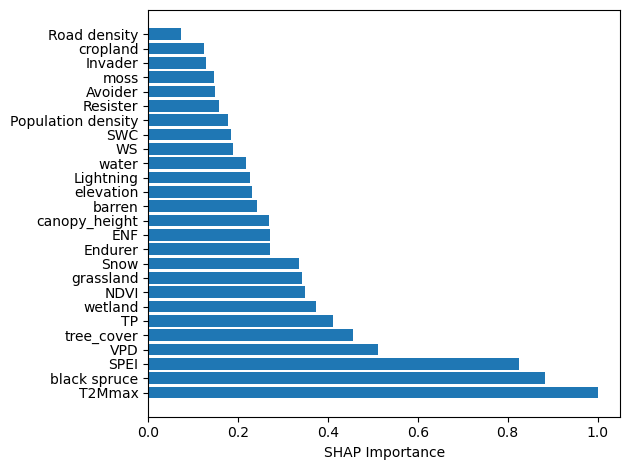

In [4]:
explainer = shap.TreeExplainer(model_23, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
print(shap_values)
print(X_train.columns)
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=True)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
plt.barh(labels, value)
plt.xlabel("SHAP Importance")
plt.tight_layout()

# 导出数据
# feature_importance_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_importance_23_2510.csv',index=False)

# # 导出绘图数据
# # 导出X_test数据和shap_values
# X_test.to_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_23_2510.csv', index=False)
# shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
# shap_values_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_23_2510.csv', index=False)

#### shap 变量交互分析

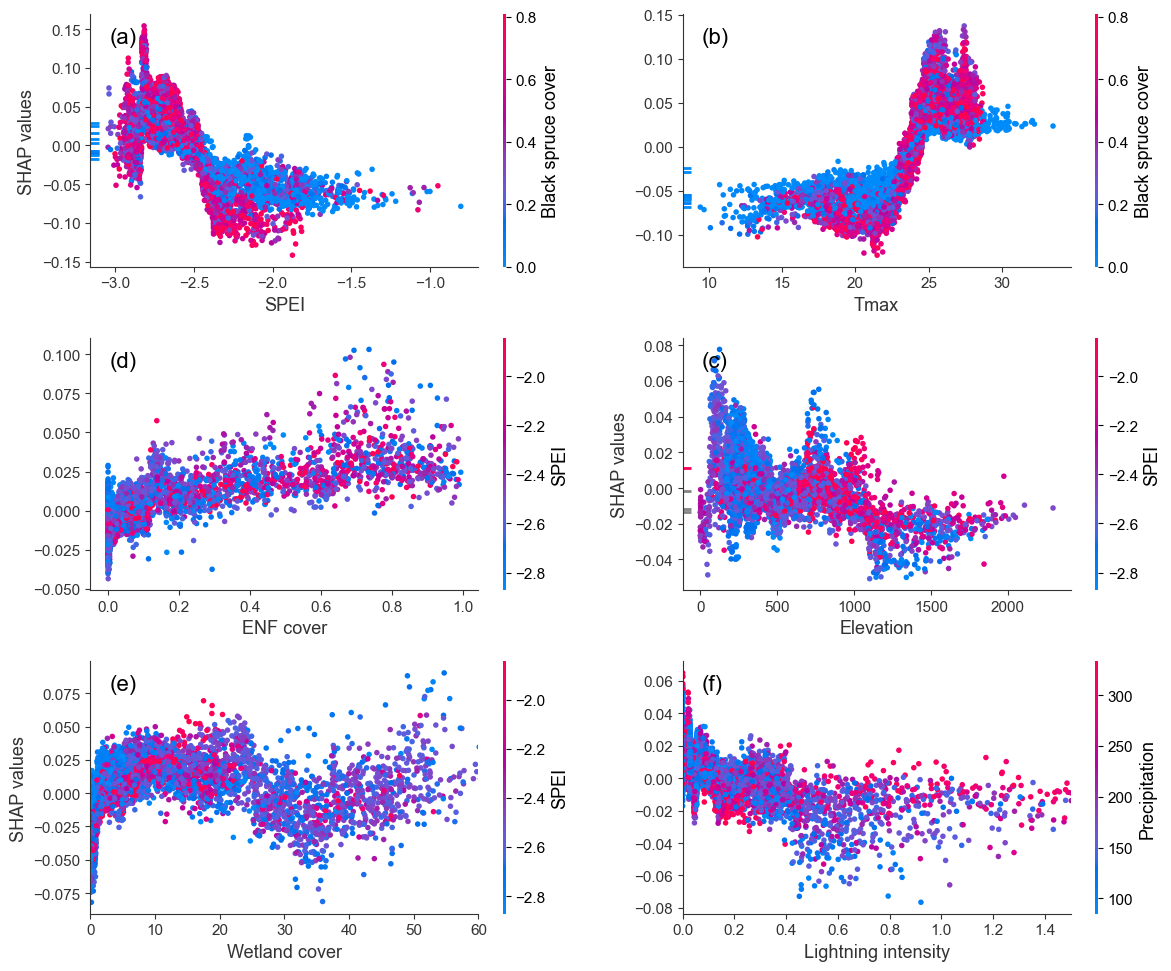

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

explainer = shap.TreeExplainer(model_23, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train)

# 定义一个从蓝色到红色的渐变colormap，不包含白色
colors = ["red","yellow", "white"]  # 定义起止颜色
n_bins = 100  # 定义渐变的细度
cmap_name = "my_custom_cmap"

# 创建LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# 创建子图
fig, ax = plt.subplots(3, 2, figsize=(12, 10))
plt.rcParams.update({'font.size': 16, 'font.family': 'Arial'})
# x轴范围设为0-500
# ax[0, 0].set_xlim(0, 1)

# Xtrain重命名

im1 = shap.dependence_plot('SPEI', shap_values, X_train, 
                     interaction_index='black spruce', ax=ax[0, 0], show=False)
ax[0, 0].text(0.05, 0.95, '(a)', transform=ax[0, 0].transAxes, fontsize=16, verticalalignment='top')
ax[0, 0].set_ylabel("SHAP values")
ax[0, 0].set_xlabel("SPEI")
# 修改colorbar的title
# 获取 colorbar 并修改标题
cbar = plt.gcf().get_axes()[-1]  # 获取 colorbar 轴
cbar.set_ylabel("Black spruce cover")

shap.dependence_plot('T2Mmax', shap_values, X_train, 
                     interaction_index='black spruce', ax=ax[0, 1], show=False)
ax[0, 1].text(0.05, 0.95, '(b)', transform=ax[0, 1].transAxes, fontsize=16, verticalalignment='top')
# 取消y轴label
ax[0, 1].set_ylabel("")
ax[0, 1].set_xlabel("Tmax")
# 获取 colorbar 并修改标题
cbar = plt.gcf().get_axes()[-1]  # 获取 colorbar 轴
cbar.set_ylabel("Black spruce cover")

shap.dependence_plot('elevation', shap_values, X_train, 
                     interaction_index='SPEI', ax=ax[1, 1], show=False)
ax[1, 1].text(0.05, 0.95, '(c)', transform=ax[1, 1].transAxes, fontsize=16, verticalalignment='top')
#ax[1, 0].set_ylim(-0.7, 0.55)
ax[1, 1].set_ylabel("SHAP values")
ax[1, 1].set_xlabel("Elevation")
# 获取 colorbar 并修改标题
cbar = plt.gcf().get_axes()[-1]  # 获取 colorbar 轴
cbar.set_ylabel("SPEI")

shap.dependence_plot('ENF', shap_values, X_train, 
                     interaction_index='SPEI', ax=ax[1, 0], show=False)
ax[1, 0].text(0.05, 0.95, '(d)', transform=ax[1, 0].transAxes, fontsize=16, verticalalignment='top')
#ax[1, 1].set_ylim(-0.7, 0.55)
# ax[1, 1].set_xlim(0,9)
ax[1, 0].set_ylabel("")
ax[1, 0].set_xlabel("ENF cover")

shap.dependence_plot('wetland', shap_values, X_train, 
                     interaction_index='SPEI', ax=ax[2, 0], show=False)
ax[2, 0].text(0.05, 0.95, '(e)', transform=ax[2, 0].transAxes, fontsize=16, verticalalignment='top')
ax[2, 0].set_ylabel("SHAP values")
ax[2, 0].set_xlabel("Wetland cover")
ax[2, 0].set_xlim(0, 60)
# 获取 colorbar 并修改标题
cbar = plt.gcf().get_axes()[-1]  # 获取 colorbar 轴
cbar.set_ylabel("SPEI")

shap.dependence_plot('Lightning', shap_values, X_train, 
                     interaction_index='TP', ax=ax[2, 1], show=False)
ax[2, 1].text(0.05, 0.95, '(f)', transform=ax[2, 1].transAxes, fontsize=16, verticalalignment='top')
ax[2, 1].set_ylabel("")
ax[2, 1].set_xlim(0, 1.5)
ax[2, 1].set_xlabel("Lightning intensity")
# 获取 colorbar 并修改标题
cbar = plt.gcf().get_axes()[-1]  # 获取 colorbar 轴
cbar.set_ylabel("Precipitation")

# 图像左右间距
plt.tight_layout()
#plt.savefig('D:/Documents/Fig/Dependence_plot_23_TP_2506.png', dpi=300, bbox_inches='tight')

#### 二元交互shap图

C:\Users\Administrator\AppData\Local\Temp\ipykernel_29576\2240059905.py:113: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(f2, ax=ax_right, color="black", vertical=True, linewidth=1.5, fill=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29576\2240059905.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


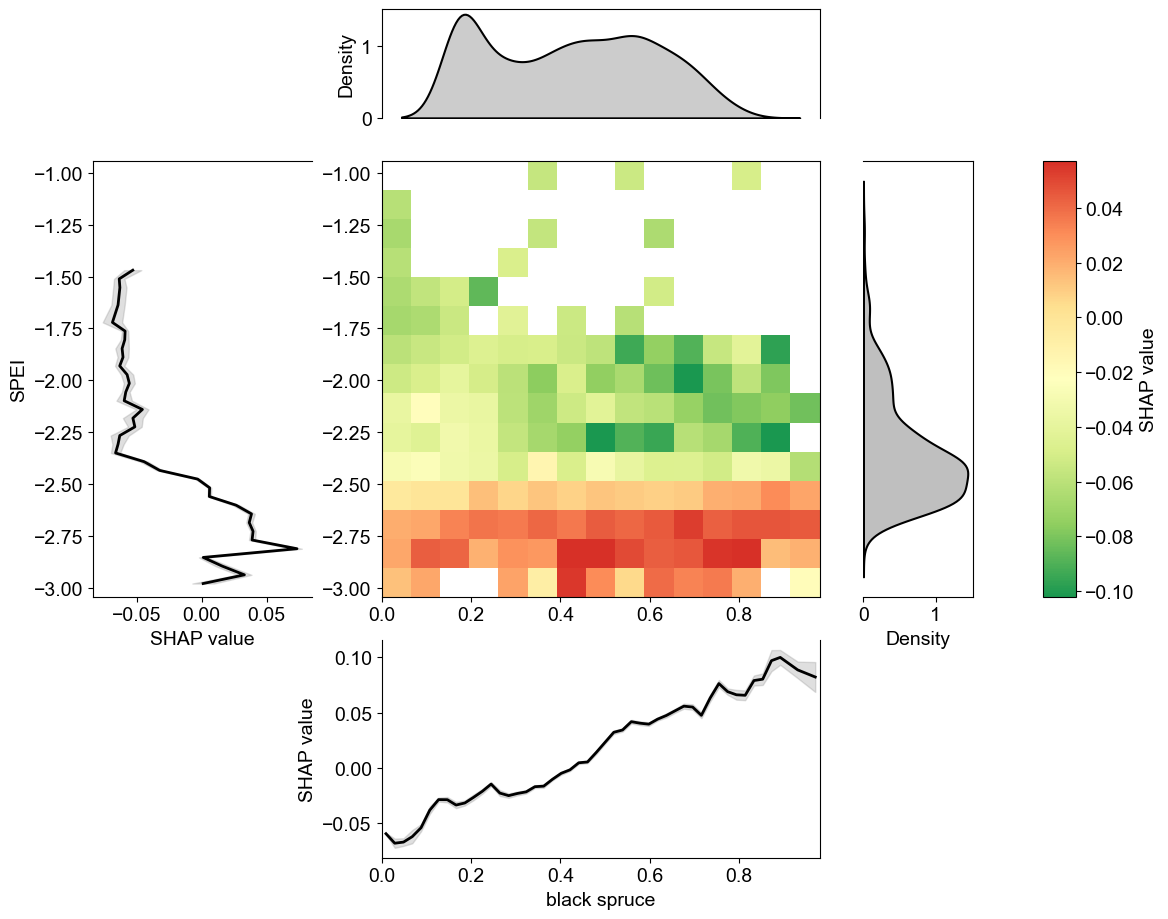

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib.gridspec import GridSpec

plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

# =====================================================
# 函数1：求 SHAP binned curve
# =====================================================
def compute_shap_binned(feature, shap_values, n_bins=40):
    x = feature.values
    y = shap_values

    bins = np.linspace(np.min(x), np.max(x), n_bins + 1)

    centers, means, se, counts = [], [], [], []

    for i in range(n_bins):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if mask.sum() > 3:
            centers.append((bins[i] + bins[i+1]) / 2)
            means.append(np.mean(y[mask]))
            se.append(np.std(y[mask]) / np.sqrt(mask.sum()))
            counts.append(mask.sum())

    return np.array(centers), np.array(means), np.array(se), np.array(counts)


# =====================================================
# 函数2：主函数 —— 论文级版 SHAP interaction + 边际效应分离
# =====================================================

def plot_shap_interaction_full(
        X_data, shap_values,
        feature1, feature2,
        n_bins=30, n_bins_marginal=40,
        figsize=(13, 13), title=None
):
    # -----------------------------
    # 提取数据
    # -----------------------------
    f1_idx = X_data.columns.get_loc(feature1)
    f2_idx = X_data.columns.get_loc(feature2)

    f1 = X_data[feature1].values
    f2 = X_data[feature2].values
    shap_f1 = shap_values[:, f1_idx]
    shap_f2 = shap_values[:, f2_idx]

    mask = ~(np.isnan(f1) | np.isnan(f2))
    f1, f2 = f1[mask], f2[mask]
    shap_f1, shap_f2 = shap_f1[mask], shap_f2[mask]

    # -----------------------------
    # 计算 SHAP 二维 binned surface
    # -----------------------------
    statistic, x_edges, y_edges, _ = binned_statistic_2d(
        f1, f2, shap_f2, statistic='mean',
        bins=[n_bins, n_bins]
    )

    vmin, vmax = np.nanpercentile(statistic, [1, 99])

    cmap_r = LinearSegmentedColormap.from_list(
        'custom',
        ['#d73027', '#fc8d59', '#fee090', '#ffffbf',
         '#d9ef8b', '#91cf60', '#1a9850'
         ],
        N=256
    )
    # 反转 colormap
    cmap = cmap_r.reversed()
    
    # -----------------------------
    # 准备 binned SHAP marginal curves - 修复：使用过滤后的数据
    # -----------------------------
    # 创建过滤后的 DataFrame 用于 compute_shap_binned
    f1_series = pd.Series(f1, name=feature1)
    f2_series = pd.Series(f2, name=feature2)
    
    c1, m1, se1, n1 = compute_shap_binned(f1_series, shap_f1, n_bins_marginal)
    c2, m2, se2, n2 = compute_shap_binned(f2_series, shap_f2, n_bins_marginal)

    # -----------------------------
    # Figure layout
    # -----------------------------
    fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(
        4, 4,
        height_ratios=[1, 4, 2, 1],
        width_ratios=[2, 4, 1, 1],
        hspace=0.2, wspace=0.2
    )

    # ------------------------------------------
    # (A) 上侧 density 图：feature1 - 修复这里的参数
    # ------------------------------------------
    ax_top = fig.add_subplot(gs[0, 1])
    sns.kdeplot(f1, ax=ax_top, color="black", linewidth=1.5, fill=True, alpha=0.2)
    ax_top.set_xticks([])
    ax_top.set_ylabel("Density")
    ax_top.spines['bottom'].set_visible(False)

    # ------------------------------------------
    # (B) 右侧 density 图：feature2 - 修复这里的参数
    # ------------------------------------------
    ax_right = fig.add_subplot(gs[1, 2])
    sns.kdeplot(f2, ax=ax_right, color="black", vertical=True, linewidth=1.5, fill=True)
    ax_right.set_xlabel("Density")
    ax_right.set_yticks([])
    ax_right.spines['left'].set_visible(False)

    # ------------------------------------------
    # (C) 中央主图：SHAP 二维 surface
    # ------------------------------------------
    ax_main = fig.add_subplot(gs[1, 1])
    im = ax_main.pcolormesh(
        x_edges, y_edges, statistic.T,
        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto"
    )
    # ax_main.set_xlabel(feature1, fontweight="bold")
    # ax_main.set_ylabel(feature2, fontweight="bold")

    # ------------------------------------------
    # (D) 左侧：SHAP response curve（feature2）
    # ------------------------------------------
    ax_left = fig.add_subplot(gs[1, 0], sharey=ax_main)

    ax_left.plot(m2, c2, 'k-', linewidth=2)
    ax_left.fill_betweenx(c2, m2 - se2, m2 + se2, color='gray', alpha=0.25)
    box_left = ax_left.get_position()
    ax_left.set_position([box_left.x0 - 0.02, box_left.y0, box_left.width, box_left.height])
    ax_left.set_xlabel("SHAP value")
    ax_left.set_ylabel(feature2)
    ax_left.spines['right'].set_visible(False)

    # ------------------------------------------
    # (E) 下侧：SHAP response curve（feature1）
    # ------------------------------------------
    ax_bottom = fig.add_subplot(gs[2, 1], sharex=ax_main)

    ax_bottom.plot(c1, m1, 'k-', linewidth=2)
    ax_bottom.fill_between(c1, m1 - se1, m1 + se1, color='gray', alpha=0.25)

    ax_bottom.set_ylabel("SHAP value")
    ax_bottom.set_xlabel(feature1)
    ax_bottom.spines['top'].set_visible(False)

    # ------------------------------------------
    # (F) colorbar
    # ------------------------------------------
    cax = fig.add_subplot(gs[1, 3])
    box = cax.get_position()
    cax.set_position([box.x0 + 0.02, box.y0, box.width * 0.3, box.height])
    fig.colorbar(im, cax=cax, label="SHAP value")
    plt.tight_layout()

    return fig

# =====================================================
# 使用示例
# =====================================================
# 修改函数调用，使用匹配的数据集
explainer = shap.TreeExplainer(model_23, feature_perturbation="tree_path_dependent")
shap_values_train = explainer.shap_values(X_test)  # 计算测试集的SHAP值

fig = plot_shap_interaction_full(
    X_test,
    shap_values_train,
    feature1="black spruce",
    feature2="SPEI",
    n_bins=15,
    n_bins_marginal=50,
    figsize=(13, 13),
)

plt.savefig("D:/Documents/Fig/shap_interaction_full_final.png", dpi=300, bbox_inches='tight')
plt.show()


#### test

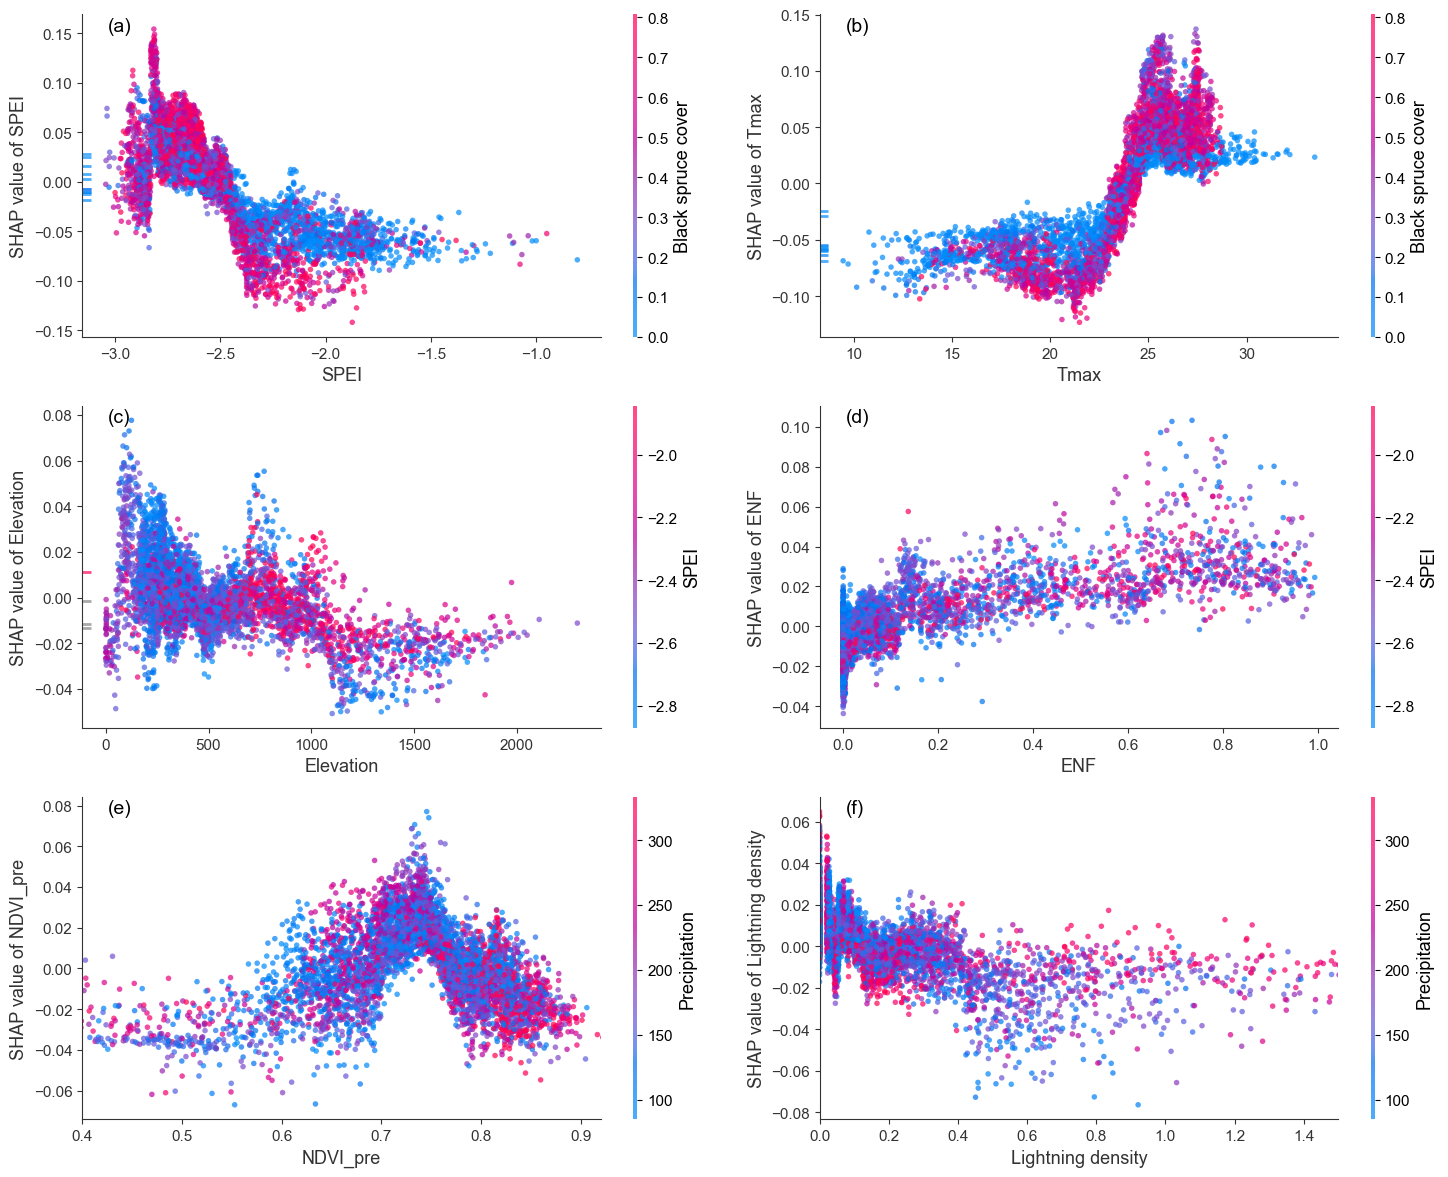

In [51]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1. 计算 shap 值
# ===============================
explainer = shap.TreeExplainer(model_23)
shap_values = explainer.shap_values(X_train)  # 旧版接口返回 ndarray

# ===============================
# 2. 设置绘图组合（3行2列）
# ===============================
feature_pairs = [
    ('SPEI', 'black spruce'),
    ('T2Mmax', 'black spruce'),
    ('elevation', 'SPEI'),
    ('ENF', 'SPEI'),
    ('NDVI', 'TP'),
    ('Lightning', 'TP')
]
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# ===============================
# 3. 循环绘制每一对子图
# ===============================
for ax, (main_feat, color_feat) in zip(axes, feature_pairs):
    shap.dependence_plot(
        main_feat,
        shap_values,
        X_train,
        interaction_index=color_feat,
        ax=ax,
        show=False,      # 不弹出单图
        alpha=0.7,       # 点透明度
       # cmap='YlOrRd'  # 颜色映射
    )
   # ax.set_title(f"{main_feat} × {color_feat}", fontsize=12, weight='bold')

# 调整每个子图的label和limit
# 子图添加（a）、（b）...标签
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(axes):
    main_feat, color_feat = feature_pairs[i]
    ax.set_xlabel(main_feat)
    ax.set_ylabel("SHAP value of " + main_feat)
    ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, )
    
    # 根据具体变量调整x轴范围
    if main_feat == 'T2Mmax':
        ax.set_xlabel("Tmax")
        ax.set_ylabel("SHAP value of Tmax")
    elif main_feat == 'NDVI':
        ax.set_xlabel("NDVI_pre")
        ax.set_ylabel("SHAP value of NDVI_pre")
        ax.set_xlim(0.4, 0.92)
    elif main_feat == 'elevation':
        ax.set_xlabel("Elevation")
        ax.set_ylabel("SHAP value of Elevation")
    elif main_feat == 'Lightning':
        ax.set_xlabel("Lightning density")
        ax.set_ylabel("SHAP value of Lightning density")
        ax.set_xlim(0, 1.5)

    if color_feat == 'black spruce':
        ax.collections[0].colorbar.set_label("Black spruce cover")
    elif color_feat == 'TP':
        ax.collections[0].colorbar.set_label("Precipitation")
    elif color_feat == 'SPEI':
        ax.collections[0].colorbar.set_label("SPEI")
    elif color_feat == 'ENF':
        ax.collections[0].colorbar.set_label("ENF cover")
    
# ===============================
# 4. 优化布局
# ===============================
plt.tight_layout()
plt.savefig('D:/Documents/Fig/Dependence_plot_shap_interaction.jpg', dpi=300, bbox_inches='tight')
plt.show()


## 2020-2022 model

### 变量对CatBooost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error



# === 1️⃣ 找出高相关变量对 ===
threshold = 0.7
corr_matrix = data_his_pro.drop(columns=["BA_fraction"]).corr()
colinearity_couplers = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i in range(len(corr_matrix.columns))
    for j in range(i)
    if abs(corr_matrix.iloc[i, j]) > threshold
]
print(f"找到 {len(colinearity_couplers)} 对高相关变量。\n")

# === 2️⃣ 初始化 ===
# 取出colinearity_predictors的唯一值
colinearity_predictors = set()
for pair in colinearity_couplers:
    colinearity_predictors.update(pair)
# 转为列表
colinearity_predictors = list(colinearity_predictors)
# 从所有变量中移除高相关变量，得到正常变量列表
normal_predictors = [col for col in data_his_pro.columns if col != "BA_fraction" and col not in colinearity_predictors]
all_predictors = normal_predictors + colinearity_predictors
# 初始输入变量集为正常变量集合
input_predictors = set(all_predictors.copy())
removed_predictors = set()

# === 3️⃣ 固定数据划分 ===
X_all = data_his_pro.drop(columns=["BA_fraction"])
y_all = data_his_pro["BA_fraction"]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=34, shuffle=True)

# === 4️⃣ 模型构建函数 ===
def build_model():
    return CatBoostRegressor(
        l2_leaf_reg=20,
        learning_rate=0.03111, # 0.063111
        depth=7,
        iterations=1500,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 300  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

# === 5️⃣ 遍历每对高相关变量 ===
for idx, (pred1, pred2) in enumerate(colinearity_couplers):
    print(f"\n{'='*70}")
    print(f"[{idx+1}/{len(colinearity_couplers)}] 当前测试的变量对：({pred1}, {pred2})")
    
    # 检查是否已经被删除
    if pred1 in removed_predictors and pred2 in removed_predictors:
        print(f"⏭️ 两个变量都已被删除，跳过")
        continue
    elif pred1 in removed_predictors:
        print(f"⏭️ {pred1} 已被删除，自动保留 {pred2}")
        input_predictors.add(pred2)
        continue
    elif pred2 in removed_predictors:
        print(f"⏭️ {pred2} 已被删除，自动保留 {pred1}")
        input_predictors.add(pred1)
        continue

    print(f"当前 input_predictors 中是否包含它们：{pred1} -> {pred1 in input_predictors}, {pred2} -> {pred2 in input_predictors}")

    # --- 模型1：保留 pred1，移除 pred2 ---
    temp_predictors_1 = list(input_predictors.union({pred1}) - {pred2})
    X_train_1 = X_train[temp_predictors_1]
    X_test_1 = X_test[temp_predictors_1]
    
    model_1 = build_model()
    model_1.fit(Pool(X_train_1, y_train), eval_set=Pool(X_test_1, y_test))
    y_pred_1 = model_1.predict(X_test_1)
    r2_1 = r2_score(y_test, y_pred_1)

    # --- 模型2：保留 pred2，移除 pred1 ---
    temp_predictors_2 = list(input_predictors.union({pred2}) - {pred1})
    X_train_2 = X_train[temp_predictors_2]
    X_test_2 = X_test[temp_predictors_2]
    
    model_2 = build_model()
    model_2.fit(Pool(X_train_2, y_train), eval_set=Pool(X_test_2, y_test))
    y_pred_2 = model_2.predict(X_test_2)
    r2_2 = r2_score(y_test, y_pred_2)

    # ✅ 使用变量名而非硬编码
    print(f"→ 保留 {pred1:25} (移除 {pred2:15}) | R² = {r2_1:.4f} | 特征数 = {len(temp_predictors_1)}")
    print(f"→ 保留 {pred2:25} (移除 {pred1:15}) | R² = {r2_2:.4f} | 特征数 = {len(temp_predictors_2)}")

    # --- 对比结果 ---
    tolerance = 0.002
    diff = abs(r2_1 - r2_2)
    
    if r2_1 > r2_2 + tolerance:
        winner, loser = pred1, pred2
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_1 - r2_2:.4f})")
    elif r2_2 > r2_1 + tolerance:
        winner, loser = pred2, pred1
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_2 - r2_1:.4f})")
    else:
        winner, loser = pred1, pred2
        print(f"⚖️ 二者性能相近 (差异: {diff:.4f})，默认保留 {winner}，删除 {loser}")
    
    input_predictors.add(winner)
    input_predictors.discard(loser)
    removed_predictors.add(loser)
    
    print(f"当前已删除变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
    print(f"当前保留变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

print("\n" + "="*70)
print("=== 共线性筛选完成 ===")
print(f"删除的变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
print(f"最终保留的变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

找到 20 对高相关变量。


[1/20] 当前测试的变量对：(ISI, FFMC)
当前 input_predictors 中是否包含它们：ISI -> True, FFMC -> True
→ 保留 ISI                       (移除 FFMC           ) | R² = 0.4474 | 特征数 = 35
→ 保留 FFMC                      (移除 ISI            ) | R² = 0.4518 | 特征数 = 35
✅ 保留 FFMC，删除 ISI (R²差异: 0.0043)
当前已删除变量 (1): ['ISI']
当前保留变量 (35): ['Avoider', 'BUI', 'Biomass', 'DC', 'DMC', 'ENF', 'Embracer', 'Endurer', 'FFMC', 'FWI', 'Invader', 'Lightning', 'NDVI', 'PET', 'Population density', 'Resister', 'Road density', 'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 'black spruce', 'canopy_height', 'cropland', 'elevation', 'forest_age', 'grassland', 'moss', 'tree_cover', 'water', 'wetland']

[2/20] 当前测试的变量对：(BUI, ISI)
⏭️ ISI 已被删除，自动保留 BUI

[3/20] 当前测试的变量对：(DMC, ISI)
⏭️ ISI 已被删除，自动保留 DMC

[4/20] 当前测试的变量对：(DMC, BUI)
当前 input_predictors 中是否包含它们：DMC -> True, BUI -> True
→ 保留 DMC                       (移除 BUI            ) | R² = 0.4559 | 特征数 = 34
→ 保留 BUI                       (移除 DMC            ) | R² = 0

#### 变量对效果

In [26]:
final_predictors = ['Avoider', 'Biomass', 'ENF', 'Embracer','T2Mmax', 'VPD',
                     'Endurer', 'FWI', 'Invader', 'Lightning', 'NDVI',
                       'Population density', 'Resister', 'Road density',
                         'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'barren', 'forest_age',
                         'black spruce', 'cropland', 'elevation', 'tree_cover',
                           'grassland', 'moss', 'water', 'wetland']
X_his = data_his_pro[final_predictors]
y_his = data_his_pro['BA_fraction']

# 2505 基于分层采样的模型数据获取
X_train, X_test, y_train, y_test = train_test_split(X_his, y_his, train_size=0.8, random_state=34, shuffle=True)

train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_his = CatBoostRegressor(
        l2_leaf_reg=2,
        learning_rate=0.03111, # 0.063111
        depth=7,
        iterations=1500,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 300  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

model_his.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_his.get_best_score())
pred = model_his.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_his.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.08401548085641664}, 'validation': {'RMSE': 0.17553687297396905}}
r2_score in train set: 0.8636085281704476
RMSE of CatBoost model in train set: 0.08403014668360552
r2_score in test set: 0.45852751134359393
RMSE of CatBoost model in test set: 0.1755368734355277


#### 最终模型效果

In [3]:
final_predictors = ['Avoider', 'Biomass', 'ENF', 'Embracer','T2Mmax', 'VPD',
                     'Endurer', 'FWI', 'Invader', 'Lightning', 'NDVI',
                       'Population density', 'Resister', 'Road density',
                         'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'barren', 'forest_age',
                         'black spruce', 'cropland', 'elevation', 'tree_cover',
                           'grassland', 'moss', 'water', 'wetland']
X_his = data_his_pro[final_predictors]
y_his = data_his_pro['BA_fraction']

X_train, X_test, y_train, y_test = train_test_split(X_his, y_his, train_size=0.8,  random_state=34, shuffle=True)


train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_his =  CatBoostRegressor(
        l2_leaf_reg=20,
        learning_rate=0.063111, # 0.063111
        depth=7,
        iterations=1500,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 300  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

model_his.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_his.get_best_score())
pred = model_his.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_his.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.09058661384153903}, 'validation': {'RMSE': 0.17635699885339542}}
r2_score in train set: 0.8409370010323742
RMSE of CatBoost model in train set: 0.09074570872745553
r2_score in test set: 0.45345606465487154
RMSE of CatBoost model in test set: 0.17635699924868126


#### 重要性分析

[[ 0.00488693  0.00208945 -0.00552593 ... -0.00050073 -0.00926166
  -0.00200747]
 [-0.01417186  0.00314851  0.00366011 ... -0.00014458 -0.01188033
  -0.00685229]
 [ 0.01157801  0.0062048   0.00123491 ... -0.00154145  0.02191598
  -0.00471188]
 ...
 [ 0.00249805  0.00289002 -0.00215908 ...  0.00184947 -0.00063226
  -0.00040868]
 [-0.01850396 -0.0091727   0.00027222 ... -0.00051355 -0.00402801
  -0.00083085]
 [ 0.00166317  0.00302368 -0.00063765 ...  0.00056506  0.0023554
  -0.00198402]]
Index(['Avoider', 'Biomass', 'ENF', 'Embracer', 'T2Mmax', 'VPD', 'Endurer',
       'FWI', 'Invader', 'Lightning', 'NDVI', 'Population density', 'Resister',
       'Road density', 'SPEI', 'SWC', 'Snow', 'TP', 'WS', 'barren',
       'forest_age', 'black spruce', 'cropland', 'elevation', 'tree_cover',
       'grassland', 'moss', 'water', 'wetland'],
      dtype='object')


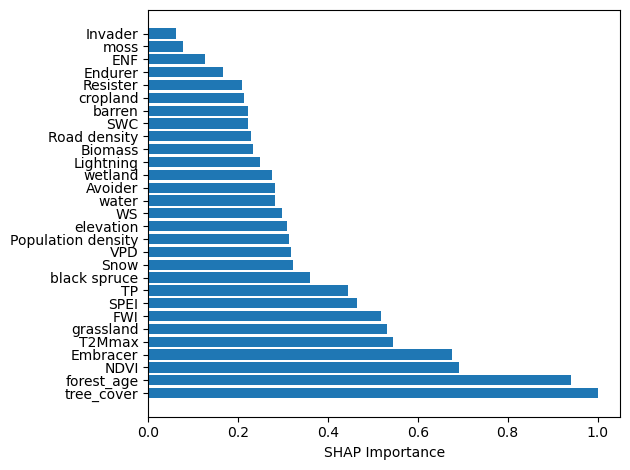

In [4]:
explainer = shap.TreeExplainer(model_his, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
print(shap_values)
print(X_train.columns)
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=True)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
plt.barh(labels, value)
plt.xlabel("SHAP Importance")
plt.tight_layout()

# # 导出数据
# feature_importance_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_importance_his_2510.csv',index=False)
# # 导出绘图数据
# # 导出X_test数据和shap_values
# X_test.to_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_his_2510.csv', index=False)
# shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
# shap_values_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_his_2510.csv', index=False)


## 2022 model

### 变量对CatBoost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error



# === 1️⃣ 找出高相关变量对 ===
threshold = 0.7
corr_matrix = data_22_pro.drop(columns=["BA_fraction"]).corr()
colinearity_couplers = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i in range(len(corr_matrix.columns))
    for j in range(i)
    if abs(corr_matrix.iloc[i, j]) > threshold
]
print(f"找到 {len(colinearity_couplers)} 对高相关变量。\n")

# === 2️⃣ 初始化 ===
# 取出colinearity_predictors的唯一值
colinearity_predictors = set()
for pair in colinearity_couplers:
    colinearity_predictors.update(pair)
# 转为列表
colinearity_predictors = list(colinearity_predictors)
# 从所有变量中移除高相关变量，得到正常变量列表
normal_predictors = [col for col in data_22_pro.columns if col != "BA_fraction" and col not in colinearity_predictors]
all_predictors = normal_predictors + colinearity_predictors
# 初始输入变量集为正常变量集合
input_predictors = set(all_predictors.copy())
removed_predictors = set()

# === 3️⃣ 固定数据划分 ===
X_all = data_22_pro.drop(columns=["BA_fraction"])
y_all = data_22_pro["BA_fraction"]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=18, shuffle=True)

# === 4️⃣ 模型构建函数 ===
def build_model():
    return CatBoostRegressor(
        l2_leaf_reg=1,
        learning_rate=0.04278052,
        depth=8,
        iterations=3000,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model = True,
        early_stopping_rounds= 300
    )

# === 5️⃣ 遍历每对高相关变量 ===
for idx, (pred1, pred2) in enumerate(colinearity_couplers):
    print(f"\n{'='*70}")
    print(f"[{idx+1}/{len(colinearity_couplers)}] 当前测试的变量对：({pred1}, {pred2})")
    
    # 检查是否已经被删除
    if pred1 in removed_predictors and pred2 in removed_predictors:
        print(f"⏭️ 两个变量都已被删除，跳过")
        continue
    elif pred1 in removed_predictors:
        print(f"⏭️ {pred1} 已被删除，自动保留 {pred2}")
        input_predictors.add(pred2)
        continue
    elif pred2 in removed_predictors:
        print(f"⏭️ {pred2} 已被删除，自动保留 {pred1}")
        input_predictors.add(pred1)
        continue

    print(f"当前 input_predictors 中是否包含它们：{pred1} -> {pred1 in input_predictors}, {pred2} -> {pred2 in input_predictors}")

    # --- 模型1：保留 pred1，移除 pred2 ---
    temp_predictors_1 = list(input_predictors.union({pred1}) - {pred2})
    X_train_1 = X_train[temp_predictors_1]
    X_test_1 = X_test[temp_predictors_1]
    
    model_1 = build_model()
    model_1.fit(Pool(X_train_1, y_train), eval_set=Pool(X_test_1, y_test))
    y_pred_1 = model_1.predict(X_test_1)
    r2_1 = r2_score(y_test, y_pred_1)

    # --- 模型2：保留 pred2，移除 pred1 ---
    temp_predictors_2 = list(input_predictors.union({pred2}) - {pred1})
    X_train_2 = X_train[temp_predictors_2]
    X_test_2 = X_test[temp_predictors_2]
    
    model_2 = build_model()
    model_2.fit(Pool(X_train_2, y_train), eval_set=Pool(X_test_2, y_test))
    y_pred_2 = model_2.predict(X_test_2)
    r2_2 = r2_score(y_test, y_pred_2)

    # ✅ 使用变量名而非硬编码
    print(f"→ 保留 {pred1:25} (移除 {pred2:15}) | R² = {r2_1:.4f} | 特征数 = {len(temp_predictors_1)}")
    print(f"→ 保留 {pred2:25} (移除 {pred1:15}) | R² = {r2_2:.4f} | 特征数 = {len(temp_predictors_2)}")

    # --- 对比结果 ---
    tolerance = 0.002
    diff = abs(r2_1 - r2_2)
    
    if r2_1 > r2_2 + tolerance:
        winner, loser = pred1, pred2
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_1 - r2_2:.4f})")
    elif r2_2 > r2_1 + tolerance:
        winner, loser = pred2, pred1
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_2 - r2_1:.4f})")
    else:
        winner, loser = pred1, pred2
        print(f"⚖️ 二者性能相近 (差异: {diff:.4f})，默认保留 {winner}，删除 {loser}")
    
    input_predictors.add(winner)
    input_predictors.discard(loser)
    removed_predictors.add(loser)
    
    print(f"当前已删除变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
    print(f"当前保留变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

print("\n" + "="*70)
print("=== 共线性筛选完成 ===")
print(f"删除的变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
print(f"最终保留的变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

找到 24 对高相关变量。


[1/24] 当前测试的变量对：(ISI, FFMC)
当前 input_predictors 中是否包含它们：ISI -> True, FFMC -> True
→ 保留 ISI                       (移除 FFMC           ) | R² = 0.4200 | 特征数 = 35
→ 保留 FFMC                      (移除 ISI            ) | R² = 0.4268 | 特征数 = 35
✅ 保留 FFMC，删除 ISI (R²差异: 0.0068)
当前已删除变量 (1): ['ISI']
当前保留变量 (35): ['Avoider', 'BUI', 'Biomass', 'DC', 'DMC', 'ENF', 'Embracer', 'Endurer', 'FFMC', 'FWI', 'Invader', 'Lightning', 'NDVI', 'PET', 'Population density', 'Resister', 'Road density', 'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 'black spruce', 'canopy_height', 'cropland', 'elevation', 'forest_age', 'grassland', 'moss', 'tree_cover', 'water', 'wetland']

[2/24] 当前测试的变量对：(BUI, FFMC)
当前 input_predictors 中是否包含它们：BUI -> True, FFMC -> True
→ 保留 BUI                       (移除 FFMC           ) | R² = 0.4293 | 特征数 = 34
→ 保留 FFMC                      (移除 BUI            ) | R² = 0.4354 | 特征数 = 34
✅ 保留 FFMC，删除 BUI (R²差异: 0.0061)
当前已删除变量 (2): ['BUI', 'ISI']
当前保留变量 (34): ['Avoi

#### 最终模型效果

In [3]:
final_predictors = ['T2Mmax', 'Population density', 'Avoider', 'Invader', 'Resister', 
                    'elevation', 'ENF', 'WS', 'Snow', 'Endurer', 'tree_cover', 'moss',
                      'black spruce', 'Biomass', 'TP', 'cropland', 'grassland', 'wetland', 
                      'SWC', 'SPEI', 'Lightning', 'barren', 'NDVI', 'Embracer', 'water', 'forest_age']
# final_predictors = final_backward_predictors
X_22 = data_22_pro[final_predictors]
y_22 = data_22_pro['BA_fraction']

X_train, X_test, y_train, y_test = train_test_split(X_22, y_22, train_size=0.8, random_state=18, shuffle=True)


train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_22 =  CatBoostRegressor(
        l2_leaf_reg=1,
        learning_rate=0.04278052,
        depth=8,
        iterations=3000,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model = True,
        early_stopping_rounds= 300
    )

model_22.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_22.get_best_score())
pred = model_22.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_22.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.0026811512302366727}, 'validation': {'RMSE': 0.1476255312613905}}
r2_score in train set: 0.9995373363988109
RMSE of CatBoost model in train set: 0.004099530088492523
r2_score in test set: 0.4420298498268863
RMSE of CatBoost model in test set: 0.14762553176861137


#### 重要性分析

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

[[-5.43360218e-03 -7.09861125e-03  7.57588093e-04 ... -1.70239491e-02
   3.00753908e-03 -1.33994150e-02]
 [ 1.33321120e-03  6.88251066e-03  1.09467378e-03 ... -1.65183097e-02
  -7.40787917e-03 -6.26809503e-04]
 [ 7.77455646e-03 -1.25220561e-02  3.69288621e-05 ... -1.80768979e-02
   2.48873409e-02  3.43592701e-02]
 ...
 [ 6.12265252e-03 -6.88488570e-03  3.50643400e-03 ...  4.00183012e-02
   1.44423290e-02  2.27184137e-02]
 [ 2.12869534e-03  3.27441082e-03 -8.88694656e-03 ...  2.40239019e-02
  -1.08638960e-02  2.79604003e-02]
 [ 3.29865979e-03  1.14683249e-02  1.04633135e-02 ... -1.29449465e-03
   3.72236974e-03  2.14762812e-02]]
Index(['T2Mmax', 'Population density', 'Avoider', 'Invader', 'Resister',
       'elevation', 'ENF', 'WS', 'Snow', 'Endurer', 'tree_cover', 'moss',
       'black spruce', 'Biomass', 'TP', 'cropland', 'grassland', 'wetland',
       'SWC', 'SPEI', 'Lightning', 'barren', 'NDVI', 'Embracer', 'water',
       'forest_age'],
      dtype='object')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

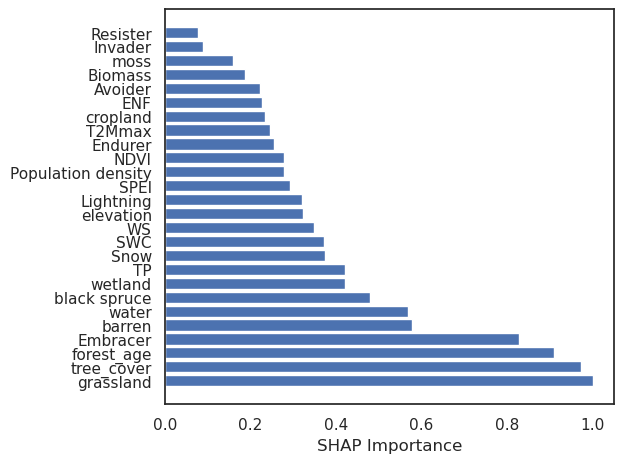

In [82]:
explainer = shap.TreeExplainer(model_22, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
print(shap_values)
print(X_train.columns)
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=True)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
plt.barh(labels, value)
plt.xlabel("SHAP Importance")
plt.tight_layout()

# 导出数据
feature_importance_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_importance_22_2510.csv',index=False)
# 导出绘图数据
# 导出X_test数据和shap_values
X_test.to_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_22_2510.csv', index=False)
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_22_2510.csv', index=False)


## 2021  model

### 变量对CatBoost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error



# === 1️⃣ 找出高相关变量对 ===
threshold = 0.7
corr_matrix = data_21_pro.drop(columns=["BA_fraction"]).corr()
colinearity_couplers = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i in range(len(corr_matrix.columns))
    for j in range(i)
    if abs(corr_matrix.iloc[i, j]) > threshold
]
print(f"找到 {len(colinearity_couplers)} 对高相关变量。\n")

# === 2️⃣ 初始化 ===
# 取出colinearity_predictors的唯一值
colinearity_predictors = set()
for pair in colinearity_couplers:
    colinearity_predictors.update(pair)
# 转为列表
colinearity_predictors = list(colinearity_predictors)
# 从所有变量中移除高相关变量，得到正常变量列表
normal_predictors = [col for col in data_21_pro.columns if col != "BA_fraction" and col not in colinearity_predictors]
all_predictors = normal_predictors + colinearity_predictors
# 初始输入变量集为正常变量集合
input_predictors = set(all_predictors.copy())
removed_predictors = set()

# === 3️⃣ 固定数据划分 ===
X_all = data_21_pro.drop(columns=["BA_fraction"])
y_all = data_21_pro["BA_fraction"]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=20, shuffle=True)

# === 4️⃣ 模型构建函数 ===
def build_model():
    return CatBoostRegressor(
        l2_leaf_reg=2,
        learning_rate=0.069996354562974185,
        depth=7,
        iterations=1500,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 60  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

# === 5️⃣ 遍历每对高相关变量 ===
for idx, (pred1, pred2) in enumerate(colinearity_couplers):
    print(f"\n{'='*70}")
    print(f"[{idx+1}/{len(colinearity_couplers)}] 当前测试的变量对：({pred1}, {pred2})")
    
    # 检查是否已经被删除
    if pred1 in removed_predictors and pred2 in removed_predictors:
        print(f"⏭️ 两个变量都已被删除，跳过")
        continue
    elif pred1 in removed_predictors:
        print(f"⏭️ {pred1} 已被删除，自动保留 {pred2}")
        input_predictors.add(pred2)
        continue
    elif pred2 in removed_predictors:
        print(f"⏭️ {pred2} 已被删除，自动保留 {pred1}")
        input_predictors.add(pred1)
        continue

    print(f"当前 input_predictors 中是否包含它们：{pred1} -> {pred1 in input_predictors}, {pred2} -> {pred2 in input_predictors}")

    # --- 模型1：保留 pred1，移除 pred2 ---
    temp_predictors_1 = list(input_predictors.union({pred1}) - {pred2})
    X_train_1 = X_train[temp_predictors_1]
    X_test_1 = X_test[temp_predictors_1]
    
    model_1 = build_model()
    model_1.fit(Pool(X_train_1, y_train), eval_set=Pool(X_test_1, y_test))
    y_pred_1 = model_1.predict(X_test_1)
    r2_1 = r2_score(y_test, y_pred_1)

    # --- 模型2：保留 pred2，移除 pred1 ---
    temp_predictors_2 = list(input_predictors.union({pred2}) - {pred1})
    X_train_2 = X_train[temp_predictors_2]
    X_test_2 = X_test[temp_predictors_2]
    
    model_2 = build_model()
    model_2.fit(Pool(X_train_2, y_train), eval_set=Pool(X_test_2, y_test))
    y_pred_2 = model_2.predict(X_test_2)
    r2_2 = r2_score(y_test, y_pred_2)

    # ✅ 使用变量名而非硬编码
    print(f"→ 保留 {pred1:25} (移除 {pred2:15}) | R² = {r2_1:.4f} | 特征数 = {len(temp_predictors_1)}")
    print(f"→ 保留 {pred2:25} (移除 {pred1:15}) | R² = {r2_2:.4f} | 特征数 = {len(temp_predictors_2)}")

    # --- 对比结果 ---
    tolerance = 0.002
    diff = abs(r2_1 - r2_2)
    
    if r2_1 > r2_2 + tolerance:
        winner, loser = pred1, pred2
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_1 - r2_2:.4f})")
    elif r2_2 > r2_1 + tolerance:
        winner, loser = pred2, pred1
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_2 - r2_1:.4f})")
    else:
        winner, loser = pred1, pred2
        print(f"⚖️ 二者性能相近 (差异: {diff:.4f})，默认保留 {winner}，删除 {loser}")
    
    input_predictors.add(winner)
    input_predictors.discard(loser)
    removed_predictors.add(loser)
    
    print(f"当前已删除变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
    print(f"当前保留变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

print("\n" + "="*70)
print("=== 共线性筛选完成 ===")
print(f"删除的变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
print(f"最终保留的变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

找到 29 对高相关变量。


[1/29] 当前测试的变量对：(ISI, FFMC)
当前 input_predictors 中是否包含它们：ISI -> True, FFMC -> True
→ 保留 ISI                       (移除 FFMC           ) | R² = 0.4675 | 特征数 = 35
→ 保留 FFMC                      (移除 ISI            ) | R² = 0.4750 | 特征数 = 35
✅ 保留 FFMC，删除 ISI (R²差异: 0.0075)
当前已删除变量 (1): ['ISI']
当前保留变量 (35): ['Avoider', 'BUI', 'Biomass', 'DC', 'DMC', 'ENF', 'Embracer', 'Endurer', 'FFMC', 'FWI', 'Invader', 'Lightning', 'NDVI', 'PET', 'Population density', 'Resister', 'Road density', 'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 'black spruce', 'canopy_height', 'cropland', 'elevation', 'forest_age', 'grassland', 'moss', 'tree_cover', 'water', 'wetland']

[2/29] 当前测试的变量对：(BUI, FFMC)
当前 input_predictors 中是否包含它们：BUI -> True, FFMC -> True
→ 保留 BUI                       (移除 FFMC           ) | R² = 0.4919 | 特征数 = 34
→ 保留 FFMC                      (移除 BUI            ) | R² = 0.4647 | 特征数 = 34
✅ 保留 BUI，删除 FFMC (R²差异: 0.0272)
当前已删除变量 (2): ['FFMC', 'ISI']
当前保留变量 (34): ['Avo

#### 最终模型效果

In [4]:
final_predictors = [ 'ENF', 'Embracer', 'Endurer', 'Invader', 
                    'Lightning', 'NDVI', 'Population density', 'Resister', 
                    'Road density', 'SWC', 'Snow', 'T2Mmax', 'TP', 'WS', 
                    'barren', 'black spruce', 'canopy_height', 'cropland','SPEI',
                      'elevation', 'forest_age', 'grassland', 'moss',
                        'tree_cover', 'water', 'wetland']
X_21 = data_21_pro[final_predictors]
y_21 = data_21_pro['BA_fraction']

# 2505 基于分层采样的模型数据获取
X_train, X_test, y_train, y_test = train_test_split(X_21, y_21, train_size=0.8, random_state=20, shuffle=True)

train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_21 = CatBoostRegressor(
        l2_leaf_reg=2,
        learning_rate=0.069996354562974185,
        depth=7,
        iterations=3000,
        random_seed=42,
        eval_metric='RMSE',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 60  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

model_21.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_21.get_best_score())
pred = model_21.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_21.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.0938281155059648}, 'validation': {'RMSE': 0.19063763578210333}}
r2_score in train set: 0.846431520481818
RMSE of CatBoost model in train set: 0.1030279098142473
r2_score in test set: 0.45981017685999026
RMSE of CatBoost model in test set: 0.19063763509586992


#### 重要性分析

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

[[-0.00256142 -0.03492134 -0.00384059 ... -0.02615168 -0.00107653
   0.01497313]
 [-0.0020644   0.00377428  0.00138453 ...  0.06972076 -0.01492041
  -0.00050083]
 [ 0.00422789  0.00747237  0.00202518 ... -0.00016748 -0.01006539
  -0.01507028]
 ...
 [-0.00390445 -0.01477999  0.0043915  ...  0.04346295 -0.02349408
   0.00179164]
 [-0.00276899 -0.00738366  0.00805796 ...  0.0162769   0.02410795
  -0.00026923]
 [-0.00700177 -0.0096115   0.00027991 ...  0.04632572 -0.01884439
   0.00129699]]
Index(['ENF', 'Embracer', 'Endurer', 'Invader', 'Lightning', 'NDVI',
       'Population density', 'Resister', 'Road density', 'SWC', 'Snow',
       'T2Mmax', 'TP', 'WS', 'barren', 'black spruce', 'canopy_height',
       'cropland', 'SPEI', 'elevation', 'forest_age', 'grassland', 'moss',
       'tree_cover', 'water', 'wetland'],
      dtype='object')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

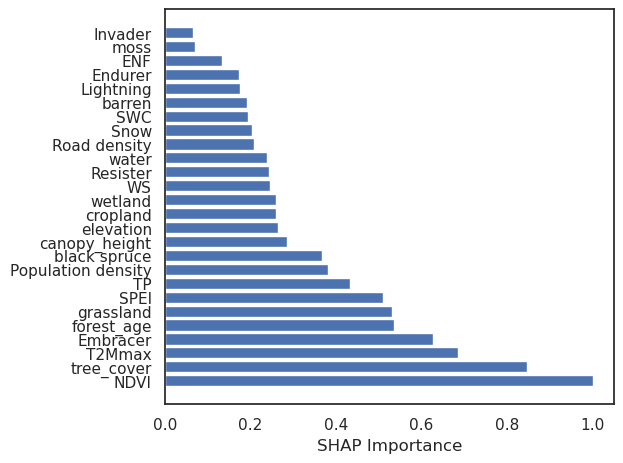

In [84]:
explainer = shap.TreeExplainer(model_21, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
print(shap_values)
print(X_train.columns)
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=True)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
plt.barh(labels, value)
plt.xlabel("SHAP Importance")
plt.tight_layout()

# 导出数据
feature_importance_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_importance_21_2510.csv',index=False)
# 导出绘图数据
# 导出X_test数据和shap_values
X_test.to_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_21_2510.csv', index=False)
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_21_2510.csv', index=False)

## 2020 model

### 变量对CatBoost

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error



# === 1️⃣ 找出高相关变量对 ===
threshold = 0.7
corr_matrix = data_20_pro.drop(columns=["BA_fraction"]).corr()
colinearity_couplers = [
    (corr_matrix.columns[i], corr_matrix.columns[j])
    for i in range(len(corr_matrix.columns))
    for j in range(i)
    if abs(corr_matrix.iloc[i, j]) > threshold
]
print(f"找到 {len(colinearity_couplers)} 对高相关变量。\n")

# === 2️⃣ 初始化 ===
# 取出colinearity_predictors的唯一值
colinearity_predictors = set()
for pair in colinearity_couplers:
    colinearity_predictors.update(pair)
# 转为列表
colinearity_predictors = list(colinearity_predictors)
# 从所有变量中移除高相关变量，得到正常变量列表
normal_predictors = [col for col in data_20_pro.columns if col != "BA_fraction" and col not in colinearity_predictors]
all_predictors = normal_predictors + colinearity_predictors
# 初始输入变量集为正常变量集合
input_predictors = set(all_predictors.copy())
removed_predictors = set()

# === 3️⃣ 固定数据划分 ===
X_all = data_20_pro.drop(columns=["BA_fraction"])
y_all = data_20_pro["BA_fraction"]
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, random_state=12, shuffle=True)

# === 4️⃣ 模型构建函数 ===
def build_model():
    return CatBoostRegressor(
        l2_leaf_reg=4,
        learning_rate=0.0249,#0.089996354562974185,
        depth=6,
        iterations=3000,
        random_seed=42,
        eval_metric='AUC',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 60  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

# === 5️⃣ 遍历每对高相关变量 ===
for idx, (pred1, pred2) in enumerate(colinearity_couplers):
    print(f"\n{'='*70}")
    print(f"[{idx+1}/{len(colinearity_couplers)}] 当前测试的变量对：({pred1}, {pred2})")
    
    # 检查是否已经被删除
    if pred1 in removed_predictors and pred2 in removed_predictors:
        print(f"⏭️ 两个变量都已被删除，跳过")
        continue
    elif pred1 in removed_predictors:
        print(f"⏭️ {pred1} 已被删除，自动保留 {pred2}")
        input_predictors.add(pred2)
        continue
    elif pred2 in removed_predictors:
        print(f"⏭️ {pred2} 已被删除，自动保留 {pred1}")
        input_predictors.add(pred1)
        continue

    print(f"当前 input_predictors 中是否包含它们：{pred1} -> {pred1 in input_predictors}, {pred2} -> {pred2 in input_predictors}")

    # --- 模型1：保留 pred1，移除 pred2 ---
    temp_predictors_1 = list(input_predictors.union({pred1}) - {pred2})
    X_train_1 = X_train[temp_predictors_1]
    X_test_1 = X_test[temp_predictors_1]
    
    model_1 = build_model()
    model_1.fit(Pool(X_train_1, y_train), eval_set=Pool(X_test_1, y_test))
    y_pred_1 = model_1.predict(X_test_1)
    r2_1 = r2_score(y_test, y_pred_1)

    # --- 模型2：保留 pred2，移除 pred1 ---
    temp_predictors_2 = list(input_predictors.union({pred2}) - {pred1})
    X_train_2 = X_train[temp_predictors_2]
    X_test_2 = X_test[temp_predictors_2]
    
    model_2 = build_model()
    model_2.fit(Pool(X_train_2, y_train), eval_set=Pool(X_test_2, y_test))
    y_pred_2 = model_2.predict(X_test_2)
    r2_2 = r2_score(y_test, y_pred_2)

    # ✅ 使用变量名而非硬编码
    print(f"→ 保留 {pred1:25} (移除 {pred2:15}) | R² = {r2_1:.4f} | 特征数 = {len(temp_predictors_1)}")
    print(f"→ 保留 {pred2:25} (移除 {pred1:15}) | R² = {r2_2:.4f} | 特征数 = {len(temp_predictors_2)}")

    # --- 对比结果 ---
    tolerance =0.01
    diff = abs(r2_1 - r2_2)
    
    if r2_1 > r2_2 + tolerance:
        winner, loser = pred1, pred2
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_1 - r2_2:.4f})")
    elif r2_2 > r2_1 + tolerance:
        winner, loser = pred2, pred1
        print(f"✅ 保留 {winner}，删除 {loser} (R²差异: {r2_2 - r2_1:.4f})")
    else:
        winner, loser = pred1, pred2
        print(f"⚖️ 二者性能相近 (差异: {diff:.4f})，默认保留 {winner}，删除 {loser}")
    
    input_predictors.add(winner)
    input_predictors.discard(loser)
    removed_predictors.add(loser)
    
    print(f"当前已删除变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
    print(f"当前保留变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

print("\n" + "="*70)
print("=== 共线性筛选完成 ===")
print(f"删除的变量 ({len(removed_predictors)}): {sorted(list(removed_predictors))}")
print(f"最终保留的变量 ({len(input_predictors)}): {sorted(list(input_predictors))}")

找到 37 对高相关变量。


[1/37] 当前测试的变量对：(ISI, FFMC)
当前 input_predictors 中是否包含它们：ISI -> True, FFMC -> True
→ 保留 ISI                       (移除 FFMC           ) | R² = 0.6163 | 特征数 = 35
→ 保留 FFMC                      (移除 ISI            ) | R² = 0.5604 | 特征数 = 35
✅ 保留 ISI，删除 FFMC (R²差异: 0.0559)
当前已删除变量 (1): ['FFMC']
当前保留变量 (35): ['Avoider', 'BUI', 'Biomass', 'DC', 'DMC', 'ENF', 'Embracer', 'Endurer', 'FWI', 'ISI', 'Invader', 'Lightning', 'NDVI', 'PET', 'Population density', 'Resister', 'Road density', 'SPEI', 'SWC', 'Snow', 'T2Mmax', 'TP', 'VPD', 'WS', 'barren', 'black spruce', 'canopy_height', 'cropland', 'elevation', 'forest_age', 'grassland', 'moss', 'tree_cover', 'water', 'wetland']

[2/37] 当前测试的变量对：(BUI, ISI)
当前 input_predictors 中是否包含它们：BUI -> True, ISI -> True
→ 保留 BUI                       (移除 ISI            ) | R² = 0.0780 | 特征数 = 34
→ 保留 ISI                       (移除 BUI            ) | R² = 0.3616 | 特征数 = 34
✅ 保留 ISI，删除 BUI (R²差异: 0.2836)
当前已删除变量 (2): ['BUI', 'FFMC']
当前保留变量 (34): ['Avoide

#### 最终模型效果

In [8]:
final_predictors = ['Embracer', 'Endurer', 'FFMC', 'FWI', 
                    'Invader', 'Lightning', 'NDVI', 'Resister',
                      'Road density', 'VPD', 'WS', 'black spruce',
                        'canopy_height', 'elevation', 'grassland',
                          'moss', 'water', 'wetland']
final_predictors = ['Embracer', 'Endurer', 'FFMC', 'FWI', 'Invader', 'Lightning', 'NDVI', 'Resister', 'Road density', 'VPD', 'WS', 'black spruce', 'canopy_height', 'elevation', 'grassland', 'moss', 'water', 'wetland']
X_20 = data_20_pro[final_predictors]
y_20 = data_20_pro['BA_fraction']

X_train, X_test, y_train, y_test = train_test_split(X_20, y_20, train_size=0.8,  random_state=12, shuffle=True)


train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model_20 = CatBoostRegressor(
        l2_leaf_reg=4,
        learning_rate=0.0249,#0.089996354562974185,
        depth=5,
        iterations=3000,
        random_seed=42,
        eval_metric='AUC',
        #objective='Poisson', 
        verbose=False,
        use_best_model=True,
        od_type= 'Iter', # early stopping parameters
        od_wait= 60  # The number of iterations to continue the training after the iteration with the optimal metric value.
    )

model_20.fit(train_pool, eval_set=validate_pool, plot=True)
print(model_20.get_best_score())
pred = model_20.predict(X_train)
print('r2_score in train set:', r2_score(y_train, pred))
print("RMSE of CatBoost model in train set:", root_mean_squared_error(y_train, pred))
pred = model_20.predict(X_test)
r2_test = r2_score(y_test, pred)
print('r2_score in test set:', r2_score(y_test, pred))
print("RMSE of CatBoost model in test set:",  root_mean_squared_error(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.0846741274454155}, 'validation': {'RMSE': 0.08749407634858483, 'AUC': 0.7128243987129286}}
r2_score in train set: 0.6853505713848774
RMSE of CatBoost model in train set: 0.0882420842196043
r2_score in test set: 0.597518107363278
RMSE of CatBoost model in test set: 0.08786289377273489


#### 重要性分析

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

[[-3.40290499e-04 -1.39678965e-03  4.45017895e-03 ...  1.20671940e-03
   1.08720919e-03  1.45203805e-03]
 [ 4.34336288e-04  2.70147908e-03  9.86448338e-03 ...  1.73667558e-03
   1.97215331e-02  2.51470541e-02]
 [-3.67903883e-04 -1.22380271e-03  3.95094901e-03 ...  1.12785038e-03
  -6.51367473e-03  2.79132615e-06]
 ...
 [-1.72763811e-04 -3.49281384e-03 -1.27480611e-02 ... -2.04095171e-03
  -4.86382049e-03 -4.84592901e-04]
 [-1.26598914e-04 -9.50568743e-04  9.90645677e-04 ...  1.25764197e-03
   6.16987064e-03  1.63394571e-03]
 [-3.64465024e-04 -1.77722269e-03  3.89867078e-03 ...  1.15324189e-03
  -8.51169349e-03  1.16088654e-03]]
Index(['Embracer', 'Endurer', 'FFMC', 'FWI', 'Invader', 'Lightning', 'NDVI',
       'Resister', 'Road density', 'VPD', 'WS', 'black spruce',
       'canopy_height', 'elevation', 'grassland', 'moss', 'water', 'wetland'],
      dtype='object')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

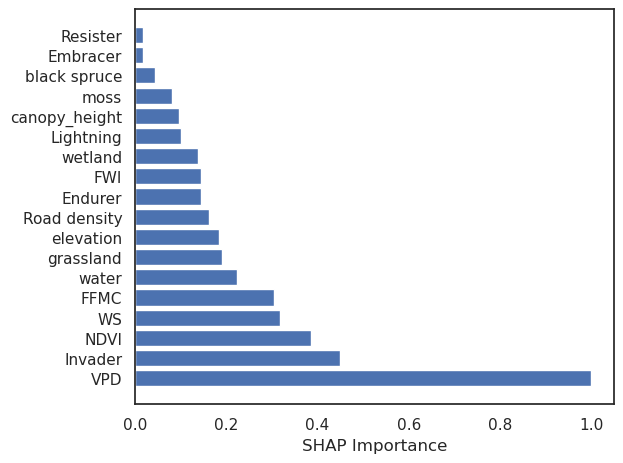

In [86]:
explainer = shap.TreeExplainer(model_20, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
print(shap_values)
print(X_train.columns)
normalized_shap_importance = np.abs(shap_values).mean(axis=0) / np.max(np.abs(shap_values).mean(axis=0))
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'SHAP Importance': normalized_shap_importance})
feature_importance_df = feature_importance_df.sort_values(by='SHAP Importance', ascending=True)
labels=list(reversed([i for i in feature_importance_df['Feature']]))
value=list(reversed([i for i in feature_importance_df['SHAP Importance']]))
plt.barh(labels, value)
plt.xlabel("SHAP Importance")
plt.tight_layout()

# 导出数据
feature_importance_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_importance_20_2510.csv',index=False)
# 导出绘图数据
# 导出X_test数据和shap_values
X_test.to_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_20_2510.csv', index=False)
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
shap_values_df.to_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_20_2510.csv', index=False)

## 绘制多个变量的重要性图

<Figure size 640x480 with 0 Axes>

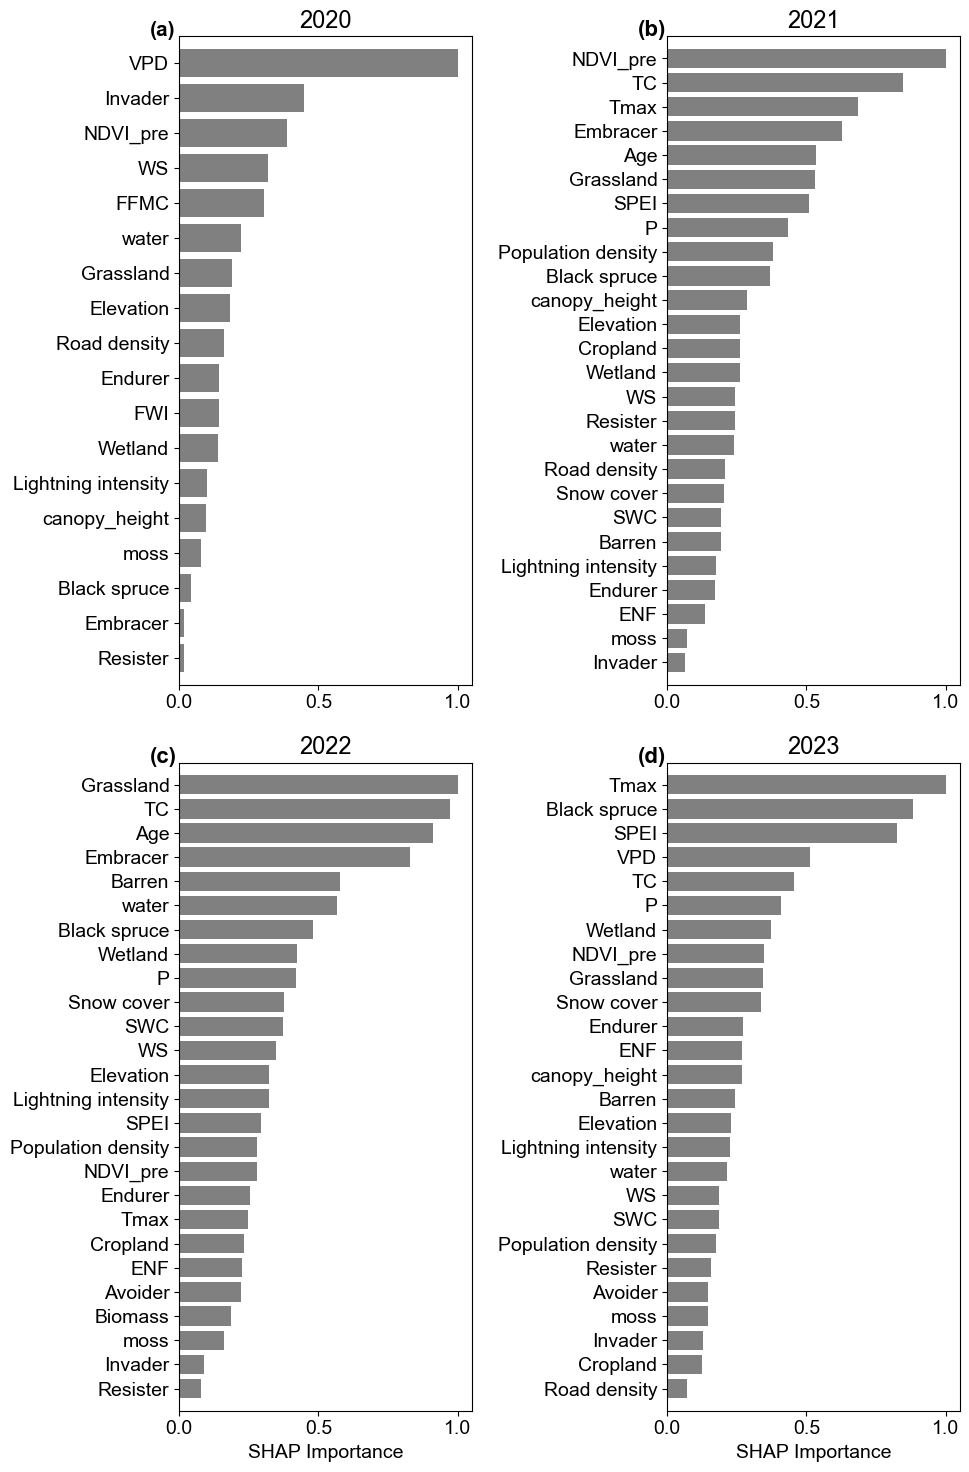

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


workDir = 'D:/Documents/outfile/catboost_model/response_analysis/'
os.chdir(workDir)

csv20path = 'shap_importance_20_2510.csv'
csv21path = 'shap_importance_21_2510.csv'
csv22path = 'shap_importance_22_2510.csv'
csv23path = 'shap_importance_23_2510.csv'
csvhispath = 'shap_importance_his_2510.csv'

# read file
df20 = pd.read_csv(csv20path)
df21 = pd.read_csv(csv21path)
df22 = pd.read_csv(csv22path)
df23 = pd.read_csv(csv23path)
dfhis = pd.read_csv(csvhispath)
'''
# 只选出后10行
df20 = df20.tail(11)
df21 = df21.tail(11)
df22 = df22.tail(11)
df23 = df23.tail(11)

# feature为‘Wind’的行改为‘WS’
#df20['Feature'] = df20['Feature'].replace('Wind', 'WS')
#df21['Feature'] = df21['Feature'].replace('Wind', 'WS')
#df22['Feature'] = df22['Feature'].replace('Wind', 'WS')
#df23['Feature'] = df23['Feature'].replace('Wind', 'WS')
# 删除’DF‘
df20 = df20.drop(df20[df20['Feature'] == 'DF'].index)
df21 = df21.drop(df21[df21['Feature'] == 'DF'].index)
df23 = df23.drop(df23[df23['Feature'] == 'DF'].index)
# 将”EF“ 改为”DF"
df22['Feature'] = df22['Feature'].replace('DF', 'EF')
# 将EF改为ENF
df20["Feature"] = df20["Feature"].replace("EF", "ENF")
df21["Feature"] = df21["Feature"].replace("EF", "ENF")
df22["Feature"] = df22["Feature"].replace("EF", "ENF")
df23["Feature"] = df23["Feature"].replace("EF", "ENF")


# 绘制变量重要性图，2*2
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.25)
# 字体设置为Arial
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
# 字号调整为16
plt.rc('font', size=16)
# 绘制20年数据的shap重要性
ax = plt.subplot(2,2,1)
# 绘制barh
plt.barh(df20['Feature'], df20['SHAP Importance'], color='grey')
# 设置x轴标签
#plt.xlabel("SHAP Importance")
# 添加标签（a)
plt.text(-0.1, 1.0, '(a)', transform=ax.transAxes, size=16, weight='bold')
# 添加标题
plt.title("2020", size=17)

# 绘制21年数据的shap重要性
ax = plt.subplot(2,2,2)
# 绘制barh
plt.barh(df21['Feature'], df21['SHAP Importance'], color='grey')
# 设置x轴标签
#plt.xlabel("SHAP Importance")
# 添加标签（b)
plt.text(-0.1, 1.0, '(b)', transform=ax.transAxes, size=16, weight='bold')
plt.title("2021", size=17)

# 绘制22年数据的shap重要性
ax = plt.subplot(2,2,3)
# 绘制barh
plt.barh(df22['Feature'], df22['SHAP Importance'], color='grey')
# 设置x轴标签
plt.xlabel("SHAP Importance")
# 添加标签（c)
plt.text(-0.1, 1.0, '(c)', transform=ax.transAxes, size=16, weight='bold')
plt.title("2022", size=17)

# 绘制23年数据的shap重要性
ax = plt.subplot(2,2,4)
# 绘制barh
plt.barh(df23['Feature'], df23['SHAP Importance'], color='grey')
# 设置x轴标签
plt.xlabel("SHAP Importance")
# 添加标签（d)
plt.text(-0.1, 1.0, '(d)', transform=ax.transAxes, size=16, weight='bold')
plt.title("2023", size=17)
plt.tight_layout()
plt.savefig("D:/Documents/Fig/shap_importance_20_23_0819.png", dpi=300, bbox_inches='tight')

'''
# 绘制第二幅
# 选出所有行
df20 = pd.read_csv(csv20path)
df21 = pd.read_csv(csv21path)
df22 = pd.read_csv(csv22path)
df23 = pd.read_csv(csv23path)
dfhis = pd.read_csv(csvhispath)

# 删除空值
df20 = df20.dropna()
df21 = df21.dropna()
df22 = df22.dropna()
df23 = df23.dropna()
dfhis = dfhis.dropna()

# feature为‘Snow’的行改为‘Snow cover’
df20['Feature'] = df20['Feature'].replace('Snow', 'Snow cover')
df21['Feature'] = df21['Feature'].replace('Snow', 'Snow cover')
df22['Feature'] = df22['Feature'].replace('Snow', 'Snow cover')
df23['Feature'] = df23['Feature'].replace('Snow', 'Snow cover')
dfhis['Feature'] = dfhis['Feature'].replace('Snow', 'Snow cover')
# tree_cover改为TC
df20['Feature'] = df20['Feature'].replace('tree_cover', 'TC')
df21['Feature'] = df21['Feature'].replace('tree_cover', 'TC')
df22['Feature'] = df22['Feature'].replace('tree_cover', 'TC')
df23['Feature'] = df23['Feature'].replace('tree_cover', 'TC')
dfhis['Feature'] = dfhis['Feature'].replace('tree_cover', 'TC')
# forest_age 改为Age
df20['Feature'] = df20['Feature'].replace('forest_age', 'Age')
df21['Feature'] = df21['Feature'].replace('forest_age', 'Age')
df22['Feature'] = df22['Feature'].replace('forest_age', 'Age')
df23['Feature'] = df23['Feature'].replace('forest_age', 'Age')
dfhis['Feature'] = dfhis['Feature'].replace('forest_age', 'Age')
# T2Mmax改为Tmax
df20['Feature'] = df20['Feature'].replace('T2Mmax', 'Tmax')
df21['Feature'] = df21['Feature'].replace('T2Mmax', 'Tmax')
df22['Feature'] = df22['Feature'].replace('T2Mmax', 'Tmax')
df23['Feature'] = df23['Feature'].replace('T2Mmax', 'Tmax')
dfhis['Feature'] = dfhis['Feature'].replace('T2Mmax', 'Tmax')
# TP 改为P
df20['Feature'] = df20['Feature'].replace('TP', 'P')
df21['Feature'] = df21['Feature'].replace('TP', 'P')
df22['Feature'] = df22['Feature'].replace('TP', 'P')
df23['Feature'] = df23['Feature'].replace('TP', 'P')
dfhis['Feature'] = dfhis['Feature'].replace('TP', 'P')
# Lightning改为Lightning Intensity
df20['Feature'] = df20['Feature'].replace('Lightning', 'Lightning intensity')
df21['Feature'] = df21['Feature'].replace('Lightning', 'Lightning intensity')
df22['Feature'] = df22['Feature'].replace('Lightning', 'Lightning intensity')
df23['Feature'] = df23['Feature'].replace('Lightning', 'Lightning intensity')
dfhis['Feature'] = dfhis['Feature'].replace('Lightning', 'Lightning intensity')
# grassland 改为Grassland
df20['Feature'] = df20['Feature'].replace('grassland', 'Grassland')
df21['Feature'] = df21['Feature'].replace('grassland', 'Grassland')
df22['Feature'] = df22['Feature'].replace('grassland', 'Grassland')
df23['Feature'] = df23['Feature'].replace('grassland', 'Grassland')
dfhis['Feature'] = dfhis['Feature'].replace('grassland', 'Grassland')
# cropland 改为Cropland
df20['Feature'] = df20['Feature'].replace('cropland', 'Cropland')
df21['Feature'] = df21['Feature'].replace('cropland', 'Cropland')
df22['Feature'] = df22['Feature'].replace('cropland', 'Cropland')
df23['Feature'] = df23['Feature'].replace('cropland', 'Cropland')
dfhis['Feature'] = dfhis['Feature'].replace('cropland', 'Cropland')
# wetland 改为Wetland
df20['Feature'] = df20['Feature'].replace('wetland', 'Wetland')
df21['Feature'] = df21['Feature'].replace('wetland', 'Wetland')
df22['Feature'] = df22['Feature'].replace('wetland', 'Wetland')
df23['Feature'] = df23['Feature'].replace('wetland', 'Wetland')
dfhis['Feature'] = dfhis['Feature'].replace('wetland', 'Wetland')
# barren 改为Barren
df20['Feature'] = df20['Feature'].replace('barren', 'Barren')
df21['Feature'] = df21['Feature'].replace('barren', 'Barren')
df22['Feature'] = df22['Feature'].replace('barren', 'Barren')
df23['Feature'] = df23['Feature'].replace('barren', 'Barren')
dfhis['Feature'] = dfhis['Feature'].replace('barren', 'Barren')
# elevation 改为Elevation
df20['Feature'] = df20['Feature'].replace('elevation', 'Elevation')
df21['Feature'] = df21['Feature'].replace('elevation', 'Elevation')
df22['Feature'] = df22['Feature'].replace('elevation', 'Elevation')
df23['Feature'] = df23['Feature'].replace('elevation', 'Elevation')
dfhis['Feature'] = dfhis['Feature'].replace('elevation', 'Elevation')
# black spruce 改为Black spruce
df20['Feature'] = df20['Feature'].replace('black spruce', 'Black spruce')
df21['Feature'] = df21['Feature'].replace('black spruce', 'Black spruce')
df22['Feature'] = df22['Feature'].replace('black spruce', 'Black spruce')
df23['Feature'] = df23['Feature'].replace('black spruce', 'Black spruce')
dfhis['Feature'] = dfhis['Feature'].replace('black spruce', 'Black spruce')
# NDVI 改为NDVI_pre
df20['Feature'] = df20['Feature'].replace('NDVI', 'NDVI_pre')
df21['Feature'] = df21['Feature'].replace('NDVI', 'NDVI_pre')
df22['Feature'] = df22['Feature'].replace('NDVI', 'NDVI_pre')
df23['Feature'] = df23['Feature'].replace('NDVI', 'NDVI_pre')
dfhis['Feature'] = dfhis['Feature'].replace('NDVI', 'NDVI_pre')
# save
csv20pro_path = 'shap_importance_20_pro_2506.csv'
csv21pro_path = 'shap_importance_21_pro_2506.csv'
csv22pro_path = 'shap_importance_22_pro_2506.csv'
csv23pro_path = 'shap_importance_23_pro_2506.csv'
csvhispro_path = 'shap_importance_his_pro_2506.csv'
df20.to_csv(csv20pro_path, index=False)
df21.to_csv(csv21pro_path, index=False)
df22.to_csv(csv22pro_path, index=False)
df23.to_csv(csv23pro_path, index=False)
dfhis.to_csv(csvhispro_path, index=False)

# 清空画布
plt.clf()
# 绘制变量重要性图，2*2
fig, axs = plt.subplots(2, 2, figsize=(10, 15))
# 字体设置为Arial
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
# 字号调整为16
plt.rc('font', size=16)
# 绘制20年数据的shap重要性
ax = plt.subplot(2,2,1)
# 绘制barh
plt.barh(df20['Feature'], df20['SHAP Importance'], color='grey')
# 设置x轴标签
#plt.xlabel("SHAP Importance")
# 添加标签（a)
plt.text(-0.1, 1.0, '(a)', transform=ax.transAxes, size=15, weight='bold')
# 添加标题
plt.title("2020", size=17)
ax.margins(y=0.02)

# 绘制21年数据的shap重要性
ax = plt.subplot(2,2,2)
# 绘制barh
plt.barh(df21['Feature'], df21['SHAP Importance'], color='grey')
# 设置x轴标签
#plt.xlabel("SHAP Importance")
# 添加标签（b)
plt.text(-0.1, 1.0, '(b)', transform=ax.transAxes, size=16, weight='bold')
plt.title("2021", size=17)
ax.margins(y=0.02)

# 绘制22年数据的shap重要性
ax = plt.subplot(2,2,3)
# 绘制barh
plt.barh(df22['Feature'], df22['SHAP Importance'], color='grey')
# 设置x轴标签
plt.xlabel("SHAP Importance")
# 添加标签（c)
plt.text(-0.1, 1.0, '(c)', transform=ax.transAxes, size=16, weight='bold')
plt.title("2022", size=17)
ax.margins(y=0.02)

# 绘制23年数据的shap重要性
ax = plt.subplot(2,2,4)
# 绘制barh
plt.barh(df23['Feature'], df23['SHAP Importance'], color='grey')
# 设置x轴标签
plt.xlabel("SHAP Importance")
# 添加标签（d)
plt.text(-0.1, 1.0, '(d)', transform=ax.transAxes, size=16, weight='bold')
plt.title("2023", size=17)
ax.margins(y=0.02)
plt.tight_layout()
plt.savefig("D:/Documents/Fig/shap_importance_20_23_all_2510.png", dpi=300, bbox_inches='tight')


## 重绘重要性及pdf变化图

18        NDVI_pre
19         Wetland
20               P
21              TC
22             VPD
23            SPEI
24    Black spruce
25            Tmax
Name: Feature, dtype: object


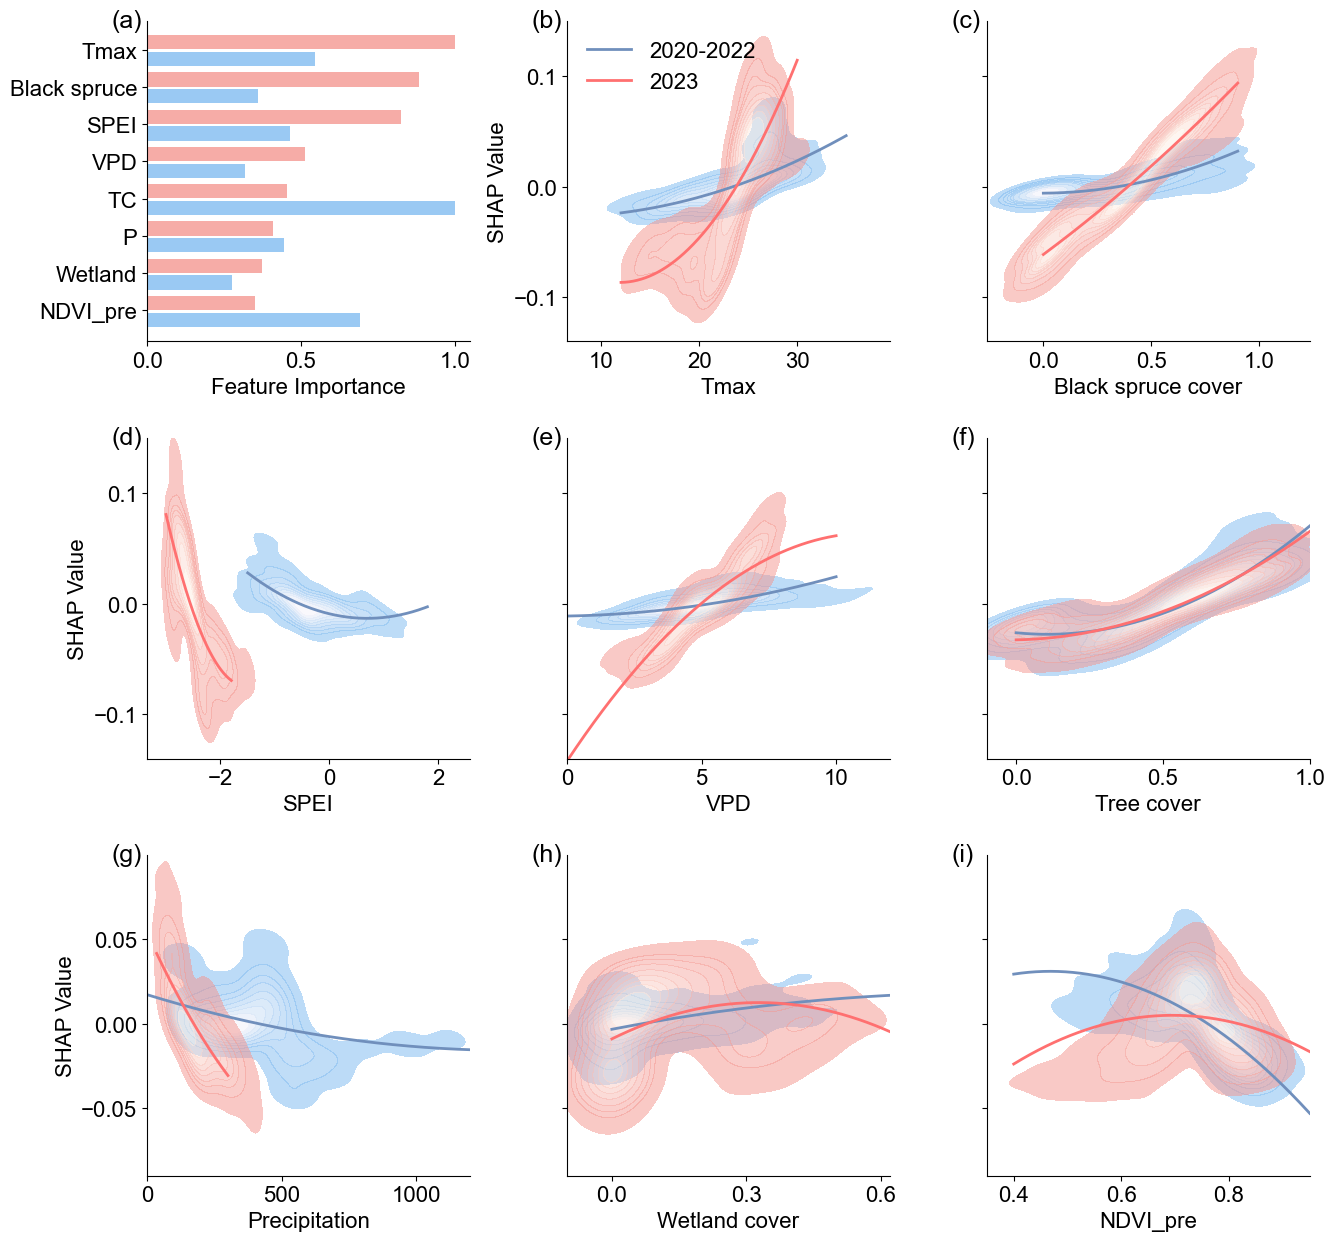

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.interpolate import splev, splrep # 数据平滑插值
import matplotlib.colors as colors
import scipy.stats as st
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# 读取绘图数据
X_test_his = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_his_2510.csv')
X_test_23 = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_23_2510.csv')
shap_values_his = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_his_2510.csv')
shap_values_23 = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_23_2510.csv')

# 重命名Columns name
X_test_his = X_test_his.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})
X_test_23 = X_test_23.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})
shap_values_his = shap_values_his.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})
shap_values_23 = shap_values_23.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})

# X_test_his和X_test_23的TC列和Snow cover列的值都除以100
X_test_his['TC'] = X_test_his['TC'] / 100
X_test_23['TC'] = X_test_23['TC'] / 100
X_test_his['Snow'] = X_test_his['Snow'] / 100
X_test_23['Snow'] = X_test_23['Snow'] / 100
X_test_his['Wetland'] = X_test_his['Wetland'] / 100
X_test_23['Wetland'] = X_test_23['Wetland'] / 100

workDir = 'D:/Documents/outfile/catboost_model/response_analysis/'
os.chdir(workDir)


# 2510
csv23path = 'shap_importance_23_2510.csv'
csvhispath = 'shap_importance_his_2510.csv'

# 读取数据
df23 = pd.read_csv(csv23path)
dfhis = pd.read_csv(csvhispath)

# 修改feature名称
df23['Feature'] = df23['Feature'].replace('T2Mmax', 'Tmax')
dfhis['Feature'] = dfhis['Feature'].replace('T2Mmax', 'Tmax')
df23['Feature'] = df23['Feature'].replace('forest_age', 'Age')
dfhis['Feature'] = dfhis['Feature'].replace('forest_age', 'Age')
df23['Feature'] = df23['Feature'].replace('tree_cover', 'TC')
dfhis['Feature'] = dfhis['Feature'].replace('tree_cover', 'TC')
df23['Feature'] = df23['Feature'].replace('TP', 'P')
dfhis['Feature'] = dfhis['Feature'].replace('TP', 'P')
df23['Feature'] = df23['Feature'].replace('Lightning', 'Lightning intensity')
dfhis['Feature'] = dfhis['Feature'].replace('Lightning', 'Lightning intensity')
df23['Feature'] = df23['Feature'].replace('black spruce', 'Black spruce')
dfhis['Feature'] = dfhis['Feature'].replace('black spruce', 'Black spruce')
df23['Feature'] = df23['Feature'].replace('NDVI', 'NDVI_pre')
dfhis['Feature'] = dfhis['Feature'].replace('NDVI', 'NDVI_pre')
df23['Feature'] = df23['Feature'].replace('grassland', 'Grassland')
dfhis['Feature'] = dfhis['Feature'].replace('grassland', 'Grassland')
df23['Feature'] = df23['Feature'].replace('cropland', 'Cropland')
dfhis['Feature'] = dfhis['Feature'].replace('cropland', 'Cropland')
df23['Feature'] = df23['Feature'].replace('wetland', 'Wetland')
dfhis['Feature'] = dfhis['Feature'].replace('wetland', 'Wetland')
df23['Feature'] = df23['Feature'].replace('barren', 'Barren')
dfhis['Feature'] = dfhis['Feature'].replace('barren', 'Barren')
df23['Feature'] = df23['Feature'].replace('elevation', 'Elevation')
dfhis['Feature'] = dfhis['Feature'].replace('elevation', 'Elevation')

# 只选出后10行
df23 = df23.tail(8)
#dfhis = dfhis.tail(10)


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

trunc_cmap_23 = truncate_colormap(plt.get_cmap("OrRd_r"), 0.5, 1)
trunc_cmap_his = truncate_colormap(plt.get_cmap("PuBuGn_r"), 0.5, 1)

# 自定义colormap
color_start_23 = plt.get_cmap("OrRd")(0)
color_start_his = plt.get_cmap("PuBuGn")(0)
color_end_23 = "#E92A28"
color_end_his = "#78b8f0"
# 创建自定义colormap
cmap23 = colors.LinearSegmentedColormap.from_list("custom", [ color_end_23, color_start_23,])
cmaphis = colors.LinearSegmentedColormap.from_list("custom", [ color_end_his, color_start_his,])
cmap23 = colors.LinearSegmentedColormap.from_list("custom", [color_end_23, color_start_23 ,])
trunc_cmap_23 = truncate_colormap(cmap23, 0.5, 1)

# 创建3*3的画布
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.25)

# 字体设置为Arial
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})
# 字号调整为16
plt.rc('font', size=16)

# 分别绘制同一变量在历史数据和23年数据中的 SHAP 重要性分布
Features_23 = df23['Feature']
width = 0.4  # 设置柱子的宽度
space = 0.05  # 设置柱子间的间隔
multiplier = 0  # 偏移量计数器
y_pos_23 = np.arange(len(Features_23))  # 设置y轴的位置
y_pos_his = [i - width - space for i in y_pos_23]
color_start = plt.get_cmap("OrRd_r")(0.05)
# 设置color为"OrRd_r"色条上最右边的值
color23 = plt.get_cmap("OrRd_r")(0.55)
colorhis = plt.get_cmap("PuBuGn_r")(0.55)
print(Features_23)

# 绘制重要性柱状图
for i, feature in enumerate(Features_23):
    importance_23 = df23[df23['Feature'] == feature]['SHAP Importance'].values[0]
    importance_his = dfhis[dfhis['Feature'] == feature]['SHAP Importance'].values[0]
                                                                 #"#e05b66"
    axs[0, 0].barh(y_pos_23[i], importance_23, width-0.02, color=cmap23(0.5), label='2023' if i == 0 else "", alpha=0.75)
    axs[0, 0].barh(y_pos_his[i], importance_his, width-0.02, color="#78b8f0", label='2020-2023' if i == 0 else "", alpha=0.75)

axs[0, 0].set_yticks([i - width / 2 for i in y_pos_23])  # 设置y轴的中点作为刻度位置
axs[0, 0].set_yticklabels(Features_23)  # 设置y轴的标签为Feature名称
axs[0, 0].set_xlabel("Feature Importance")  # 设置x轴标签

# 绘制偏依赖图

features = ["Tmax", "Black spruce", "SPEI",  "VPD", "TC", "P", "Wetland", "NDVI_pre" ]
x1=[np.linspace(12,30,1000), np.linspace(0,0.9,1000), np.linspace(-3,-1.8,1000),np.linspace(0,10,1000),np.linspace(0,1,1000), np.linspace(35,300,1000),np.linspace(0,0.62,1000),  np.linspace(0.4,0.95,1000) ]
x_tick = [np.linspace(12,35,3), np.linspace(0,0.9,3),np.linspace(-3,2,3), np.linspace(0,11,3), np.linspace(0,1,3), np.linspace(0,1200,3), np.linspace(0,0.62,3), np.linspace(0.35,1,3)]
x2=[np.linspace(12,35,1000), np.linspace(0,0.9,1000),np.linspace(-1.5, 1.8,1000), np.linspace(0,10,1000),np.linspace(0,1,1000),np.linspace(0,1200,1000),np.linspace(0,0.62,1000), np.linspace(0.4,0.95,1000)]


plt.subplots_adjust(wspace=0.3,hspace=0.3)#
#plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 2)
cl = np.array([(255,112,112),(112,143,188)])
cl=cl/255
# 分别绘制同一变量在历史数据和23年数据中的shap重要性分布
for i in range(len(features)):
    ax = plt.subplot(3,3,i+2)

    feature_idx=X_test_his.columns.get_loc(features[i])
    shap_values_feature_his = shap_values_his[features[i]]
    kde_plot = sns.kdeplot(x=X_test_his[features[i]], y=shap_values_feature_his, cmap=cmaphis, alpha=0.5,fill=True,ax=ax)

    feature_idx=X_test_23.columns.get_loc(features[i])
    shap_values_feature_23 = shap_values_23[features[i]]
    kde_plot = sns.kdeplot(x=X_test_23[features[i]], y=shap_values_feature_23, cmap=trunc_cmap_23, alpha=0.5,fill=True,ax=ax)
    
    # 一元二次方程拟合
    x=X_test_his[features[i]]
    y=shap_values_feature_his
    # 删除nan值
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    poly=np.polyfit(x,y,2)

    y_fit=np.polyval(poly,x2[i])
    plt.plot(x2[i],y_fit,color=cl[1],linewidth=2)

    x=X_test_23[features[i]]
    y=shap_values_feature_23
    # 删除nan值
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    poly=np.polyfit(x,y,2)
    y_fit=np.polyval(poly,x1[i])
    plt.plot(x1[i],y_fit,color=cl[0],linewidth=2)

    # y轴标签
    if i == 0 or i == 2 or i == 5:
        ax.set_ylabel('SHAP Value')
    else:
        ax.set_ylabel('')
    

    # x轴
    if i == 1: 
        ax.set_xlabel('Black spruce cover')
    if i == 7: # NDVI
        ax.set_xlim(0.35, 0.95)
        ax.set_xticks([0.4,0.6,0.8])

    if i == 3:
        ax.set_xlim(0, 12)
        ax.set_xticks([0,5,10])
    if i == 4:
        ax.set_xlabel('Tree cover')
        ax.set_xlim(-0.10, 1)
        ax.set_xticks([0,0.5,1])
    if i == 5:
        ax.set_xlabel('Precipitation')
        ax.set_xlim(0, 1200)
        ax.set_xticks([0,500,1000])
    if i == 6:
        ax.set_xlabel('Wetland cover')
        ax.set_xlim(-0.1, 0.62)
        ax.set_xticks([0,0.3,0.6])

    # if i==8:
    #     ax.set_xlim(25, 75)

    # 修改y轴
    if i == 0 or i == 1:
        ax.set_ylim(-0.14, 0.15)
        ax.set_yticks([-0.1, 0, 0.1])
    if i == 2 or i == 3 or i == 4:
        ax.set_ylim(-0.14, 0.15)
        ax.set_yticks([-0.1, 0, 0.1])
    if i == 5 or i == 6 or i == 7:
        ax.set_ylim(-0.09, 0.1)
        ax.set_yticks([-0.05, 0, 0.05])
    if i != 0 and i != 2 and i != 5:
        ax.set_yticklabels([])
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)

axs[0, 0].text(-0.11, 0.98, '(a)', fontsize=18, transform=axs[0, 0].transAxes)
axs[0, 1].text(-0.11, 0.98, '(b)', fontsize=18, transform=axs[0, 1].transAxes)
axs[0, 2].text(-0.11, 0.98, '(c)', fontsize=18, transform=axs[0, 2].transAxes)
axs[1, 0].text(-0.11, 0.98, '(d)', fontsize=18, transform=axs[1, 0].transAxes)
axs[1, 1].text(-0.11, 0.98, '(e)', fontsize=18, transform=axs[1, 1].transAxes)
axs[1, 2].text(-0.11, 0.98, '(f)', fontsize=18, transform=axs[1, 2].transAxes)
axs[2, 0].text(-0.11, 0.98, '(g)', fontsize=18, transform=axs[2, 0].transAxes)
axs[2, 1].text(-0.11, 0.98, '(h)', fontsize=18, transform=axs[2, 1].transAxes)
axs[2, 2].text(-0.11, 0.98, '(i)', fontsize=18, transform=axs[2, 2].transAxes)

# 添加图例和标签
axs[0,1].legend(['2020-2022','2023'], loc="upper left", frameon=False)
from matplotlib.lines import Line2D

# 定义颜色（保持和你图中一致）
color_23 = '#E92A28'
color_his = '#708FB8'  # 蓝色

# # 在 axs[0,1] 中添加蓝色图例（2020–2022）
# axs[0,1].legend(
#    # handles=[Line2D([0], [0], color=color_his, lw=2)],
#    # labels=['2020–2022'],
#     loc='upper left',
#     frameon=False
# )

# # 在 axs[0,2] 中添加红色图例（2023）
# axs[0,2].legend(
#     handles=[Line2D([0], [0], color=color_23, lw=2)],
#     labels=['2023'],
#     loc='upper left',
#     frameon=False
# )

plt.savefig('D:/Documents/Fig/modelhis_23_PDF_com4_2510.png',dpi=500, bbox_inches='tight')

#### 单独为ENF绘制

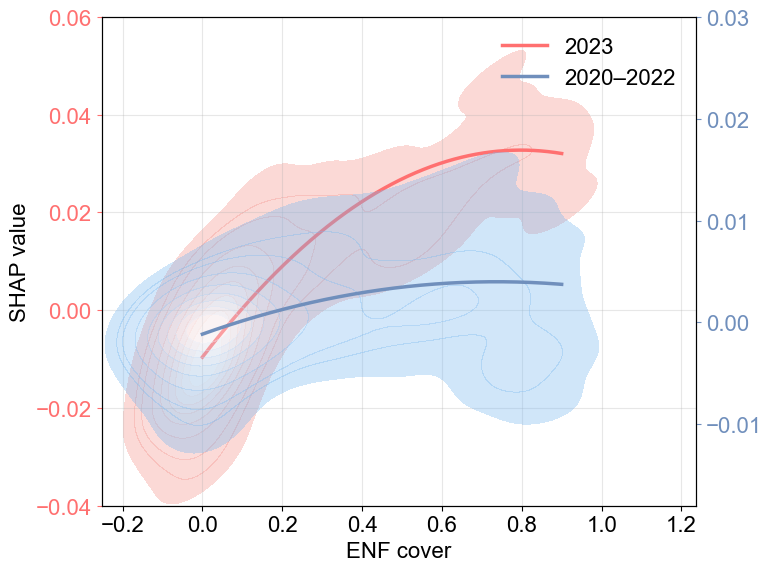

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.interpolate import splev, splrep # 数据平滑插值
import matplotlib.colors as colors
import scipy.stats as st
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# 读取绘图数据
X_test_his = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_his_2510.csv')
X_test_23 = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/X_test_23_2510.csv')
shap_values_his = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_his_2510.csv')
shap_values_23 = pd.read_csv('D:/Documents/outfile/catboost_model/response_analysis/shap_values_23_2510.csv')

# 重命名Columns name
X_test_his = X_test_his.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})
X_test_23 = X_test_23.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})
shap_values_his = shap_values_his.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})
shap_values_23 = shap_values_23.rename(columns={'T2Mmax': 'Tmax', 'forest_age': 'Age', 'tree_cover': 'TC', 'TP': 'P', 'Lightning': 'Lightning intensity', 'black spruce': 'Black spruce', 'NDVI': 'NDVI_pre', 'grassland': 'Grassland', 'cropland': 'Cropland', 'wetland': 'Wetland', 'barren': 'Barren', 'elevation': 'Elevation'})

# X_test_his和X_test_23的TC列和Snow cover列的值都除以100
X_test_his['TC'] = X_test_his['TC'] / 100
X_test_23['TC'] = X_test_23['TC'] / 100
X_test_his['Snow'] = X_test_his['Snow'] / 100
X_test_23['Snow'] = X_test_23['Snow'] / 100
X_test_his['Wetland'] = X_test_his['Wetland'] / 100
X_test_23['Wetland'] = X_test_23['Wetland'] / 100

workDir = 'D:/Documents/outfile/catboost_model/response_analysis/'
os.chdir(workDir)


# 2510
csv23path = 'shap_importance_23_2510.csv'
csvhispath = 'shap_importance_his_2510.csv'

# 读取数据
df23 = pd.read_csv(csv23path)
dfhis = pd.read_csv(csvhispath)

# 修改feature名称
df23['Feature'] = df23['Feature'].replace('T2Mmax', 'Tmax')
dfhis['Feature'] = dfhis['Feature'].replace('T2Mmax', 'Tmax')
df23['Feature'] = df23['Feature'].replace('forest_age', 'Age')
dfhis['Feature'] = dfhis['Feature'].replace('forest_age', 'Age')
df23['Feature'] = df23['Feature'].replace('tree_cover', 'TC')
dfhis['Feature'] = dfhis['Feature'].replace('tree_cover', 'TC')
df23['Feature'] = df23['Feature'].replace('TP', 'P')
dfhis['Feature'] = dfhis['Feature'].replace('TP', 'P')
df23['Feature'] = df23['Feature'].replace('Lightning', 'Lightning intensity')
dfhis['Feature'] = dfhis['Feature'].replace('Lightning', 'Lightning intensity')
df23['Feature'] = df23['Feature'].replace('black spruce', 'Black spruce')
dfhis['Feature'] = dfhis['Feature'].replace('black spruce', 'Black spruce')
df23['Feature'] = df23['Feature'].replace('NDVI', 'NDVI_pre')
dfhis['Feature'] = dfhis['Feature'].replace('NDVI', 'NDVI_pre')
df23['Feature'] = df23['Feature'].replace('grassland', 'Grassland')
dfhis['Feature'] = dfhis['Feature'].replace('grassland', 'Grassland')
df23['Feature'] = df23['Feature'].replace('cropland', 'Cropland')
dfhis['Feature'] = dfhis['Feature'].replace('cropland', 'Cropland')
df23['Feature'] = df23['Feature'].replace('wetland', 'Wetland')
dfhis['Feature'] = dfhis['Feature'].replace('wetland', 'Wetland')
df23['Feature'] = df23['Feature'].replace('barren', 'Barren')
dfhis['Feature'] = dfhis['Feature'].replace('barren', 'Barren')
df23['Feature'] = df23['Feature'].replace('elevation', 'Elevation')
dfhis['Feature'] = dfhis['Feature'].replace('elevation', 'Elevation')

# 只选出后10行
df23 = df23.tail(8)
#dfhis = dfhis.tail(10)


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

trunc_cmap_23 = truncate_colormap(plt.get_cmap("OrRd_r"), 0.5, 1)
trunc_cmap_his = truncate_colormap(plt.get_cmap("PuBuGn_r"), 0.5, 1)

# 自定义colormap
color_start_23 = plt.get_cmap("OrRd")(0)
color_start_his = plt.get_cmap("PuBuGn")(0)
color_end_23 = "#E92A28"
color_end_his = "#78b8f0"
# 创建自定义colormap
cmap23 = colors.LinearSegmentedColormap.from_list("custom", [ color_end_23, color_start_23,])
cmaphis = colors.LinearSegmentedColormap.from_list("custom", [ color_end_his, color_start_his,])
cmap23 = colors.LinearSegmentedColormap.from_list("custom", [color_end_23, color_start_23 ,])
trunc_cmap_23 = truncate_colormap(cmap23, 0.5, 1)

# ===============================
# 配置字体与样式
# ===============================
plt.rc('font', family='Arial', size=16)
plt.rc('lines', linewidth=2)

# ===============================
# 自定义配色
# ===============================
cl = np.array([(255,112,112),(112,143,188)])/255  # 红-蓝
cmap_23 = trunc_cmap_23     # 红色渐变
cmap_his = cmaphis          # 蓝色渐变

feature = "ENF"

# ===============================
# 数据准备
# ===============================
x_23 = X_test_23[feature].values
y_23 = shap_values_23[feature].values
x_his = X_test_his[feature].values
y_his = shap_values_his[feature].values

# 删除 NaN
mask_23 = ~np.isnan(x_23) & ~np.isnan(y_23)
x_23, y_23 = x_23[mask_23], y_23[mask_23]
mask_his = ~np.isnan(x_his) & ~np.isnan(y_his)
x_his, y_his = x_his[mask_his], y_his[mask_his]

# ===============================
# 创建双 y 轴画布
# ===============================
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# ===============================
# 左轴：2023 KDE + 拟合
# ===============================
sns.kdeplot(x=x_23, y=y_23, cmap=cmap_23, alpha=0.35, fill=True, ax=ax1)
poly_23 = np.polyfit(x_23, y_23, 2)
x_fit = np.linspace(0, 0.9, 500)
y_fit_23 = np.polyval(poly_23, x_fit)
ax1.plot(x_fit, y_fit_23, color=cl[0], lw=2.5, label='2023')

# ===============================
# 右轴：历史期 KDE + 拟合
# ===============================
sns.kdeplot(x=x_his, y=y_his, cmap=cmap_his, alpha=0.35, fill=True, ax=ax2)
poly_his = np.polyfit(x_his, y_his, 2)
y_fit_his = np.polyval(poly_his, x_fit)
ax2.plot(x_fit, y_fit_his, color=cl[1], lw=2.5, label='2020–2022', linestyle='-')

# ===============================
# 坐标轴美化
# ===============================
ax1.set_xlabel(f'{feature} cover')
ax1.set_ylabel('SHAP value', color='black')
ax2.set_ylabel('', color=cl[1])

ax1.tick_params(axis='y', colors=cl[0])
ax2.tick_params(axis='y', colors=cl[1])

ax1.grid(alpha=0.3)
ax1.set_ylim(-0.04, 0.06)
ax2.set_ylim(-0.018, 0.03)

# ===============================
# 图例与标题
# ===============================
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()
